# **Proyecto Final**

Andrea Gutierrez Renteria  
Isaac Emiliano Meza Lopez  
Nicole Getzabel Flores Godinez   

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import statsmodels as stm
import folium
from sklearn.preprocessing import StandardScaler
from semopy import Model, Optimizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import matplotlib.patches as mpatches




ERROR:prophet.plot:Importing plotly failed. Interactive plots will not work.


In [3]:
df_crime_data = pd.read_csv('Crime_Data_from_2020_to_Present_20250428.csv')
df_Businesses = pd.read_csv('Listing_of_All_Businesses_20250428.csv')
df_housingprices = pd.read_csv('Neighborhood_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
gdf_areaxvecindario = gpd.read_file('Neighborhood_Demographics.geojson')
#df_coordenadasxvecindario = gpd.read_file('LA_Times_Neighborhood_Boundaries.geojson')
df_poblacionxvecindario = pd.read_csv('Census_Data_by_Neighborhood_Council_20250428.csv')    

In [4]:
gdf_areaxvecindario = gpd.read_file('Neighborhood_Demographics.geojson')

## Fase 1

### **Exploración y limpieza de datos: Dataset de crimen:**

In [5]:
df_crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005199 entries, 0 to 1005198
Data columns (total 28 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   DR_NO           1005199 non-null  int64  
 1   Date Rptd       1005199 non-null  object 
 2   DATE OCC        1005199 non-null  object 
 3   TIME OCC        1005199 non-null  int64  
 4   AREA            1005199 non-null  int64  
 5   AREA NAME       1005199 non-null  object 
 6   Rpt Dist No     1005199 non-null  int64  
 7   Part 1-2        1005199 non-null  int64  
 8   Crm Cd          1005199 non-null  int64  
 9   Crm Cd Desc     1005199 non-null  object 
 10  Mocodes         853440 non-null   object 
 11  Vict Age        1005199 non-null  int64  
 12  Vict Sex        860418 non-null   object 
 13  Vict Descent    860406 non-null   object 
 14  Premis Cd       1005183 non-null  float64
 15  Premis Desc     1004611 non-null  object 
 16  Weapon Used Cd  327282 non-null   fl

In [6]:
df_crime_data.head()

DR_NO               Date Rptd                DATE OCC  TIME OCC  AREA  \
0  190326475  03/01/2020 12:00:00 AM  03/01/2020 12:00:00 AM      2130     7   
1  200106753  02/09/2020 12:00:00 AM  02/08/2020 12:00:00 AM      1800     1   
2  200320258  11/11/2020 12:00:00 AM  11/04/2020 12:00:00 AM      1700     3   
3  200907217  05/10/2023 12:00:00 AM  03/10/2020 12:00:00 AM      2037     9   
4  200412582  09/09/2020 12:00:00 AM  09/09/2020 12:00:00 AM       630     4   

    AREA NAME  Rpt Dist No  Part 1-2  Crm Cd  \
0    Wilshire          784         1     510   
1     Central          182         1     330   
2   Southwest          356         1     480   
3    Van Nuys          964         1     343   
4  Hollenbeck          413         1     510   

                                Crm Cd Desc  ... Status   Status Desc  \
0                          VEHICLE - STOLEN  ...     AA  Adult Arrest   
1                     BURGLARY FROM VEHICLE  ...     IC   Invest Cont   
2                             BIKE - STOLEN  ...     IC   Invest Cont   
3  SHOPLIFTING-GRAND THEFT ($950.01 & OVER)  ...     IC   Invest Cont   
4                          VEHICLE - STOLEN  ...     IC   Invest Cont   

  Crm Cd 1 Crm Cd 2  Crm Cd 3 Crm Cd 4  \
0    510.0    998.0       NaN      NaN   
1    330.0    998.0       NaN      NaN   
2    480.0      NaN       NaN      NaN   
3    343.0      NaN       NaN      NaN   
4    510.0      NaN       NaN      NaN   

                                   LOCATION Cross Street      LAT       LON  
0   1900 S  LONGWOOD                     AV          NaN  34.0375 -118.3506  
1   1000 S  FLOWER                       ST          NaN  34.0444 -118.2628  
2   1400 W  37TH                         ST          NaN  34.0210 -118.3002  
3  14000    RIVERSIDE                    DR          NaN  34.1576 -118.4387  
4                          200 E  AVENUE 28          NaN  34.0820 -118.2130  

[5 rows x 28 columns]

#### **Manejo de variables de fecha**

Cambiamos ambos date a formato de fecha

In [7]:
df_crime_data['Date Rptd'] = pd.to_datetime(df_crime_data['Date Rptd'], format= '%m/%d/%Y %I:%M:%S %p')

In [8]:
df_crime_data['DATE OCC'] = pd.to_datetime(df_crime_data['DATE OCC'], format= '%m/%d/%Y %I:%M:%S %p')

cambiamos Time OCC a tiempo

In [9]:
df_crime_data['TIME OCC'] = df_crime_data['TIME OCC'].astype(str).str.zfill(4)
df_crime_data['TIME OCC'] = pd.to_datetime(df_crime_data['TIME OCC'], format='%H%M').dt.time

#### **Limpieza de datos**

Vemos el porcentaje de datos nulos que tienen cada columna

In [10]:
df_crime_data.isnull().sum()/df_crime_data.shape[0] * 100

DR_NO              0.000000
Date Rptd          0.000000
DATE OCC           0.000000
TIME OCC           0.000000
AREA               0.000000
AREA NAME          0.000000
Rpt Dist No        0.000000
Part 1-2           0.000000
Crm Cd             0.000000
Crm Cd Desc        0.000000
Mocodes           15.097409
Vict Age           0.000000
Vict Sex          14.403218
Vict Descent      14.404411
Premis Cd          0.001592
Premis Desc        0.058496
Weapon Used Cd    67.441074
Weapon Desc       67.441074
Status             0.000099
Status Desc        0.000000
Crm Cd 1           0.001094
Crm Cd 2          93.119870
Crm Cd 3          99.769797
Crm Cd 4          99.993633
LOCATION           0.000000
Cross Street      84.655377
LAT                0.000000
LON                0.000000
dtype: float64

Eliminamos columnas las de Weapon Used Cd, Weapon Desc, Crm Cd 2, Crm Cd 3, Crm Cd 4 y Cross Street, ya que tienen más del 60% de datos nulos

In [11]:
df_crime_data = df_crime_data.drop(columns=['Weapon Used Cd', 'Weapon Desc', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'Cross Street'])

Checamos que filas nos faltan 

In [12]:
df_crime_data.head()

DR_NO  Date Rptd   DATE OCC  TIME OCC  AREA   AREA NAME  Rpt Dist No  \
0  190326475 2020-03-01 2020-03-01  21:30:00     7    Wilshire          784   
1  200106753 2020-02-09 2020-02-08  18:00:00     1     Central          182   
2  200320258 2020-11-11 2020-11-04  17:00:00     3   Southwest          356   
3  200907217 2023-05-10 2020-03-10  20:37:00     9    Van Nuys          964   
4  200412582 2020-09-09 2020-09-09  06:30:00     4  Hollenbeck          413   

   Part 1-2  Crm Cd                               Crm Cd Desc  ... Vict Sex  \
0         1     510                          VEHICLE - STOLEN  ...        M   
1         1     330                     BURGLARY FROM VEHICLE  ...        M   
2         1     480                             BIKE - STOLEN  ...        X   
3         1     343  SHOPLIFTING-GRAND THEFT ($950.01 & OVER)  ...        M   
4         1     510                          VEHICLE - STOLEN  ...      NaN   

   Vict Descent Premis Cd                                   Premis Desc  \
0             O     101.0                                        STREET   
1             O     128.0             BUS STOP/LAYOVER (ALSO QUERY 124)   
2             X     502.0  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)   
3             O     405.0                                CLOTHING STORE   
4           NaN     101.0                                        STREET   

   Status   Status Desc Crm Cd 1                                  LOCATION  \
0      AA  Adult Arrest    510.0   1900 S  LONGWOOD                     AV   
1      IC   Invest Cont    330.0   1000 S  FLOWER                       ST   
2      IC   Invest Cont    480.0   1400 W  37TH                         ST   
3      IC   Invest Cont    343.0  14000    RIVERSIDE                    DR   
4      IC   Invest Cont    510.0                          200 E  AVENUE 28   

       LAT       LON  
0  34.0375 -118.3506  
1  34.0444 -118.2628  
2  34.0210 -118.3002  
3  34.1576 -118.4387  
4  34.0820 -118.2130  

[5 rows x 22 columns]

In [13]:
df_crime_data.isnull().sum()/df_crime_data.shape[0] * 100

DR_NO            0.000000
Date Rptd        0.000000
DATE OCC         0.000000
TIME OCC         0.000000
AREA             0.000000
AREA NAME        0.000000
Rpt Dist No      0.000000
Part 1-2         0.000000
Crm Cd           0.000000
Crm Cd Desc      0.000000
Mocodes         15.097409
Vict Age         0.000000
Vict Sex        14.403218
Vict Descent    14.404411
Premis Cd        0.001592
Premis Desc      0.058496
Status           0.000099
Status Desc      0.000000
Crm Cd 1         0.001094
LOCATION         0.000000
LAT              0.000000
LON              0.000000
dtype: float64

Rellenamos datos nulos de Mocodes, Vict Sex, Vict Descent, Premis Cd, Premis Desc, Crm Cd 1

In [14]:
df_crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005199 entries, 0 to 1005198
Data columns (total 22 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   DR_NO         1005199 non-null  int64         
 1   Date Rptd     1005199 non-null  datetime64[ns]
 2   DATE OCC      1005199 non-null  datetime64[ns]
 3   TIME OCC      1005199 non-null  object        
 4   AREA          1005199 non-null  int64         
 5   AREA NAME     1005199 non-null  object        
 6   Rpt Dist No   1005199 non-null  int64         
 7   Part 1-2      1005199 non-null  int64         
 8   Crm Cd        1005199 non-null  int64         
 9   Crm Cd Desc   1005199 non-null  object        
 10  Mocodes       853440 non-null   object        
 11  Vict Age      1005199 non-null  int64         
 12  Vict Sex      860418 non-null   object        
 13  Vict Descent  860406 non-null   object        
 14  Premis Cd     1005183 non-null  float64       
 15

In [15]:
columnas_texto = ['Mocodes', 'Vict Sex', 'Vict Descent', 'Premis Desc', 'Status', 'Premis Cd', 'Crm Cd 1' ]
df_crime_data[columnas_texto] = df_crime_data[columnas_texto].fillna('')

chacamos que ya no hayan quedado datos nulos

In [16]:
df_crime_data.isnull().sum()/df_crime_data.shape[0] * 100

DR_NO           0.0
Date Rptd       0.0
DATE OCC        0.0
TIME OCC        0.0
AREA            0.0
AREA NAME       0.0
Rpt Dist No     0.0
Part 1-2        0.0
Crm Cd          0.0
Crm Cd Desc     0.0
Mocodes         0.0
Vict Age        0.0
Vict Sex        0.0
Vict Descent    0.0
Premis Cd       0.0
Premis Desc     0.0
Status          0.0
Status Desc     0.0
Crm Cd 1        0.0
LOCATION        0.0
LAT             0.0
LON             0.0
dtype: float64

In [17]:
df_crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005199 entries, 0 to 1005198
Data columns (total 22 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   DR_NO         1005199 non-null  int64         
 1   Date Rptd     1005199 non-null  datetime64[ns]
 2   DATE OCC      1005199 non-null  datetime64[ns]
 3   TIME OCC      1005199 non-null  object        
 4   AREA          1005199 non-null  int64         
 5   AREA NAME     1005199 non-null  object        
 6   Rpt Dist No   1005199 non-null  int64         
 7   Part 1-2      1005199 non-null  int64         
 8   Crm Cd        1005199 non-null  int64         
 9   Crm Cd Desc   1005199 non-null  object        
 10  Mocodes       1005199 non-null  object        
 11  Vict Age      1005199 non-null  int64         
 12  Vict Sex      1005199 non-null  object        
 13  Vict Descent  1005199 non-null  object        
 14  Premis Cd     1005199 non-null  object        
 15

In [18]:
df_crime_data

DR_NO  Date Rptd   DATE OCC  TIME OCC  AREA   AREA NAME  \
0        190326475 2020-03-01 2020-03-01  21:30:00     7    Wilshire   
1        200106753 2020-02-09 2020-02-08  18:00:00     1     Central   
2        200320258 2020-11-11 2020-11-04  17:00:00     3   Southwest   
3        200907217 2023-05-10 2020-03-10  20:37:00     9    Van Nuys   
4        200412582 2020-09-09 2020-09-09  06:30:00     4  Hollenbeck   
...            ...        ...        ...       ...   ...         ...   
1005194  250304203 2025-02-20 2025-02-13  21:00:00     3   Southwest   
1005195  250504051 2025-01-14 2025-01-14  12:50:00     5      Harbor   
1005196  250304284 2025-03-31 2025-03-30  21:00:00     3   Southwest   
1005197  251604136 2025-02-27 2025-02-27  15:50:00    16    Foothill   
1005198  251904210 2025-03-25 2025-03-25  12:35:00    19     Mission   

         Rpt Dist No  Part 1-2  Crm Cd  \
0                784         1     510   
1                182         1     330   
2                356         1     480   
3                964         1     343   
4                413         1     510   
...              ...       ...     ...   
1005194          325         1     522   
1005195          509         1     210   
1005196          328         1     510   
1005197         1664         1     510   
1005198         1944         2     850   

                                               Crm Cd Desc  ... Vict Sex  \
0                                         VEHICLE - STOLEN  ...        M   
1                                    BURGLARY FROM VEHICLE  ...        M   
2                                            BIKE - STOLEN  ...        X   
3                 SHOPLIFTING-GRAND THEFT ($950.01 & OVER)  ...        M   
4                                         VEHICLE - STOLEN  ...            
...                                                    ...  ...      ...   
1005194  VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, B...  ...            
1005195                                            ROBBERY  ...        F   
1005196                                   VEHICLE - STOLEN  ...            
1005197                                   VEHICLE - STOLEN  ...            
1005198                                  INDECENT EXPOSURE  ...        F   

         Vict Descent Premis Cd                                   Premis Desc  \
0                   O     101.0                                        STREET   
1                   O     128.0             BUS STOP/LAYOVER (ALSO QUERY 124)   
2                   X     502.0  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)   
3                   O     405.0                                CLOTHING STORE   
4                         101.0                                        STREET   
...               ...       ...                                           ...   
1005194                   108.0                                   PARKING LOT   
1005195             H     721.0                                   HIGH SCHOOL   
1005196                   101.0                                        STREET   
1005197                   101.0                                        STREET   
1005198             H     721.0                                   HIGH SCHOOL   

        Status   Status Desc Crm Cd 1  \
0           AA  Adult Arrest    510.0   
1           IC   Invest Cont    330.0   
2           IC   Invest Cont    480.0   
3           IC   Invest Cont    343.0   
4           IC   Invest Cont    510.0   
...        ...           ...      ...   
1005194     IC   Invest Cont    522.0   
1005195     IC   Invest Cont    210.0   
1005196     IC   Invest Cont    510.0   
1005197     AA  Adult Arrest    510.0   
1005198     IC   Invest Cont    850.0   

                                         LOCATION      LAT       LON  
0         1900 S  LONGWOOD                     AV  34.0375 -118.3506  
1         1000 S  FLOWER                       ST  34.0444 -118.2628  
2         1400 W  37TH                         ST  

#### **Manejo de variables geoespaciales**

In [19]:
# --- 1. Asegurarse que LAT y LON no tengan nulos ni ceros ---
df_crime_data = df_crime_data.dropna(subset=['LAT', 'LON'])
df_crime_data = df_crime_data[(df_crime_data['LAT'] != 0) & (df_crime_data['LON'] != 0)]

# --- 2. Crear la geometría (puntos) ---
geometry = [Point(xy) for xy in zip(df_crime_data['LON'], df_crime_data['LAT'])]

# --- 3. Crear el GeoDataFrame ---
gdf_crime_data = gpd.GeoDataFrame(df_crime_data, geometry=geometry)

# --- 4. Asignar el sistema de coordenadas (CRS estándar) ---
gdf_crime_data.set_crs(epsg=4326, inplace=True)

DR_NO  Date Rptd   DATE OCC  TIME OCC  AREA   AREA NAME  \
0        190326475 2020-03-01 2020-03-01  21:30:00     7    Wilshire   
1        200106753 2020-02-09 2020-02-08  18:00:00     1     Central   
2        200320258 2020-11-11 2020-11-04  17:00:00     3   Southwest   
3        200907217 2023-05-10 2020-03-10  20:37:00     9    Van Nuys   
4        200412582 2020-09-09 2020-09-09  06:30:00     4  Hollenbeck   
...            ...        ...        ...       ...   ...         ...   
1005194  250304203 2025-02-20 2025-02-13  21:00:00     3   Southwest   
1005195  250504051 2025-01-14 2025-01-14  12:50:00     5      Harbor   
1005196  250304284 2025-03-31 2025-03-30  21:00:00     3   Southwest   
1005197  251604136 2025-02-27 2025-02-27  15:50:00    16    Foothill   
1005198  251904210 2025-03-25 2025-03-25  12:35:00    19     Mission   

         Rpt Dist No  Part 1-2  Crm Cd  \
0                784         1     510   
1                182         1     330   
2                356         1     480   
3                964         1     343   
4                413         1     510   
...              ...       ...     ...   
1005194          325         1     522   
1005195          509         1     210   
1005196          328         1     510   
1005197         1664         1     510   
1005198         1944         2     850   

                                               Crm Cd Desc  ... Vict Descent  \
0                                         VEHICLE - STOLEN  ...            O   
1                                    BURGLARY FROM VEHICLE  ...            O   
2                                            BIKE - STOLEN  ...            X   
3                 SHOPLIFTING-GRAND THEFT ($950.01 & OVER)  ...            O   
4                                         VEHICLE - STOLEN  ...                
...                                                    ...  ...          ...   
1005194  VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, B...  ...                
1005195                                            ROBBERY  ...            H   
1005196                                   VEHICLE - STOLEN  ...                
1005197                                   VEHICLE - STOLEN  ...                
1005198                                  INDECENT EXPOSURE  ...            H   

         Premis Cd                                   Premis Desc Status  \
0            101.0                                        STREET     AA   
1            128.0             BUS STOP/LAYOVER (ALSO QUERY 124)     IC   
2            502.0  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)     IC   
3            405.0                                CLOTHING STORE     IC   
4            101.0                                        STREET     IC   
...            ...                                           ...    ...   
1005194      108.0                                   PARKING LOT     IC   
1005195      721.0                                   HIGH SCHOOL     IC   
1005196      101.0                                        STREET     IC   
1005197      101.0                                        STREET     AA   
1005198      721.0                                   HIGH SCHOOL     IC   

          Status Desc Crm Cd 1                                  LOCATION  \
0        Adult Arrest    510.0   1900 S  LONGWOOD                     AV   
1         Invest Cont    330.0   1000 S  FLOWER                       ST   
2         Invest Cont    480.0   1400 W  37TH                         ST   
3         Invest Cont    343.0  14000    RIVERSIDE                    DR   
4         Invest Cont    510.0                          200 E  AVENUE 28   
...               ...      ...                                       ...   
1005194   Invest Cont    522.0   2600    ELLENDALE                    PL   
1005195   Invest Cont    210.0  24300    WESTERN                      AV   
1005196   Invest Cont    510.0    700 W  32ND                         ST   
1005197  Adult Arrest

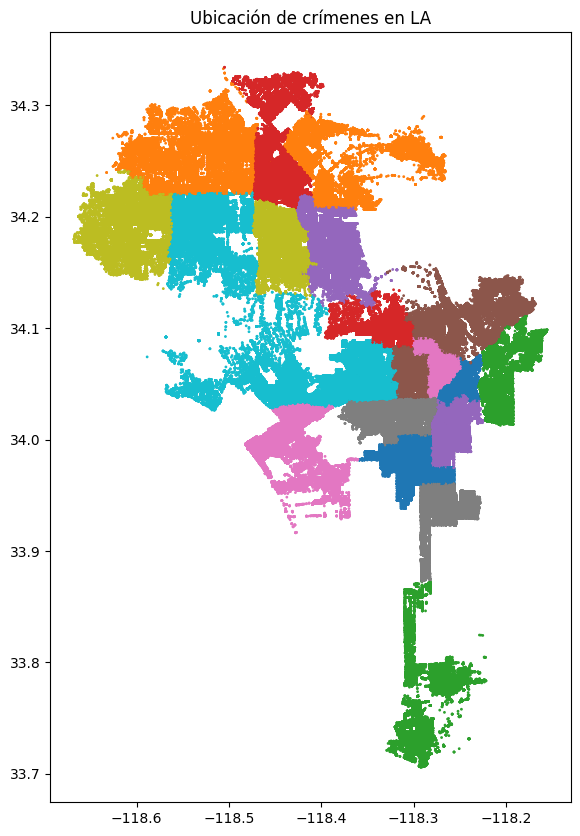

In [20]:
gdf_crime_data.plot(markersize=1, figsize=(10,10), column="AREA NAME" )
plt.title("Ubicación de crímenes en LA")
plt.show()

#### **Manejo de variables categóricas (texto)**

In [21]:
def preprocess_text(text):
    """
    Limpiar y preprocesar el texto
    """
    text = text.lower()
    
    text = re.sub(r'http\S+', '', text)
    
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    
    return ' '.join(tokens)


In [22]:
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [23]:
df_crime_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1002959 entries, 0 to 1005198
Data columns (total 22 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   DR_NO         1002959 non-null  int64         
 1   Date Rptd     1002959 non-null  datetime64[ns]
 2   DATE OCC      1002959 non-null  datetime64[ns]
 3   TIME OCC      1002959 non-null  object        
 4   AREA          1002959 non-null  int64         
 5   AREA NAME     1002959 non-null  object        
 6   Rpt Dist No   1002959 non-null  int64         
 7   Part 1-2      1002959 non-null  int64         
 8   Crm Cd        1002959 non-null  int64         
 9   Crm Cd Desc   1002959 non-null  object        
 10  Mocodes       1002959 non-null  object        
 11  Vict Age      1002959 non-null  int64         
 12  Vict Sex      1002959 non-null  object        
 13  Vict Descent  1002959 non-null  object        
 14  Premis Cd     1002959 non-null  object        
 15  Pre

In [24]:
df_crime_data['text'] = (
    df_crime_data['Crm Cd Desc'].astype(str) + ' ' +
    df_crime_data['DATE OCC'].astype(str) + ' ' +
    df_crime_data['Premis Desc'].astype(str) + ' ' +
    df_crime_data['Vict Descent'].astype(str) + ' ' +
    df_crime_data['AREA NAME'].astype(str) + ' ' +
    df_crime_data['Vict Age'].astype(str) + ' ' +
    df_crime_data['Vict Sex'].astype(str)
)

In [25]:
df_crime_data.head()

DR_NO  Date Rptd   DATE OCC  TIME OCC  AREA   AREA NAME  Rpt Dist No  \
0  190326475 2020-03-01 2020-03-01  21:30:00     7    Wilshire          784   
1  200106753 2020-02-09 2020-02-08  18:00:00     1     Central          182   
2  200320258 2020-11-11 2020-11-04  17:00:00     3   Southwest          356   
3  200907217 2023-05-10 2020-03-10  20:37:00     9    Van Nuys          964   
4  200412582 2020-09-09 2020-09-09  06:30:00     4  Hollenbeck          413   

   Part 1-2  Crm Cd                               Crm Cd Desc  ...  \
0         1     510                          VEHICLE - STOLEN  ...   
1         1     330                     BURGLARY FROM VEHICLE  ...   
2         1     480                             BIKE - STOLEN  ...   
3         1     343  SHOPLIFTING-GRAND THEFT ($950.01 & OVER)  ...   
4         1     510                          VEHICLE - STOLEN  ...   

  Vict Descent  Premis Cd                                   Premis Desc  \
0            O      101.0                                        STREET   
1            O      128.0             BUS STOP/LAYOVER (ALSO QUERY 124)   
2            X      502.0  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)   
3            O      405.0                                CLOTHING STORE   
4                   101.0                                        STREET   

  Status   Status Desc Crm Cd 1                                  LOCATION  \
0     AA  Adult Arrest    510.0   1900 S  LONGWOOD                     AV   
1     IC   Invest Cont    330.0   1000 S  FLOWER                       ST   
2     IC   Invest Cont    480.0   1400 W  37TH                         ST   
3     IC   Invest Cont    343.0  14000    RIVERSIDE                    DR   
4     IC   Invest Cont    510.0                          200 E  AVENUE 28   

       LAT       LON                                               text  
0  34.0375 -118.3506  VEHICLE - STOLEN 2020-03-01 STREET O Wilshire 0 M  
1  34.0444 -118.2628  BURGLARY FROM VEHICLE 2020-02-08 BUS STOP/LAYO...  
2  34.0210 -118.3002  BIKE - STOLEN 2020-11-04 MULTI-UNIT DWELLING (...  
3  34.1576 -118.4387  SHOPLIFTING-GRAND THEFT ($950.01 & OVER) 2020-...  
4  34.0820 -118.2130  VEHICLE - STOLEN 2020-09-09 STREET  Hollenbeck 0   

[5 rows x 23 columns]

In [26]:
df_crime_data["preprocessed_texts"] = [preprocess_text(text) for text in df_crime_data['text']]

In [27]:
tfidf = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.85)
tfidf_matrix = tfidf.fit_transform(df_crime_data["preprocessed_texts"])

In [28]:
svd = TruncatedSVD(n_components=100, random_state=42)
embeddings = svd.fit_transform(tfidf_matrix)
 
embeddings = normalize(embeddings)
explained_variance = svd.explained_variance_ratio_.sum()
print(f"Porcentaje de varianza explicada: {explained_variance:.2%}")

Porcentaje de varianza explicada: 92.85%


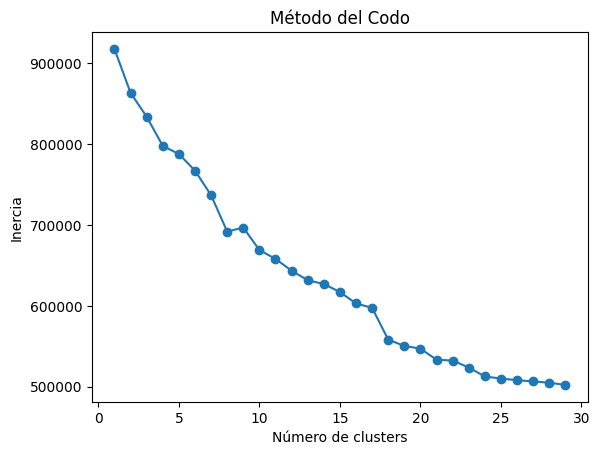

In [29]:
inertia = []
k_range = range(1, 30)
for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(embeddings)
    inertia.append(model.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

Usamos el metodo del codo para que fuera mas facil procesar los datos, y a simple vista pudimos ver que el numero de clusters optimo fue 8

In [30]:
clustering_df_crime = KMeans(n_clusters = 8, random_state=42, n_init=10)
clusters_df_crime = clustering_df_crime.fit_predict(embeddings)

df_crime_data["cluster"] = clusters_df_crime

In [31]:
df_crime_data.head()

DR_NO  Date Rptd   DATE OCC  TIME OCC  AREA   AREA NAME  Rpt Dist No  \
0  190326475 2020-03-01 2020-03-01  21:30:00     7    Wilshire          784   
1  200106753 2020-02-09 2020-02-08  18:00:00     1     Central          182   
2  200320258 2020-11-11 2020-11-04  17:00:00     3   Southwest          356   
3  200907217 2023-05-10 2020-03-10  20:37:00     9    Van Nuys          964   
4  200412582 2020-09-09 2020-09-09  06:30:00     4  Hollenbeck          413   

   Part 1-2  Crm Cd                               Crm Cd Desc  ...  \
0         1     510                          VEHICLE - STOLEN  ...   
1         1     330                     BURGLARY FROM VEHICLE  ...   
2         1     480                             BIKE - STOLEN  ...   
3         1     343  SHOPLIFTING-GRAND THEFT ($950.01 & OVER)  ...   
4         1     510                          VEHICLE - STOLEN  ...   

                                    Premis Desc  Status   Status Desc  \
0                                        STREET      AA  Adult Arrest   
1             BUS STOP/LAYOVER (ALSO QUERY 124)      IC   Invest Cont   
2  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)      IC   Invest Cont   
3                                CLOTHING STORE      IC   Invest Cont   
4                                        STREET      IC   Invest Cont   

  Crm Cd 1                                  LOCATION      LAT       LON  \
0    510.0   1900 S  LONGWOOD                     AV  34.0375 -118.3506   
1    330.0   1000 S  FLOWER                       ST  34.0444 -118.2628   
2    480.0   1400 W  37TH                         ST  34.0210 -118.3002   
3    343.0  14000    RIVERSIDE                    DR  34.1576 -118.4387   
4    510.0                          200 E  AVENUE 28  34.0820 -118.2130   

                                                text  \
0  VEHICLE - STOLEN 2020-03-01 STREET O Wilshire 0 M   
1  BURGLARY FROM VEHICLE 2020-02-08 BUS STOP/LAYO...   
2  BIKE - STOLEN 2020-11-04 MULTI-UNIT DWELLING (...   
3  SHOPLIFTING-GRAND THEFT ($950.01 & OVER) 2020-...   
4  VEHICLE - STOLEN 2020-09-09 STREET  Hollenbeck 0    

                                  preprocessed_texts cluster  
0                     vehicle stolen street wilshire       5  
1  burglary vehicle bus stoplayover also query ce...       4  
2  bike stolen multiunit dwelling apartment duple...       7  
3     shopliftinggrand theft clothing store van nuys       4  
4                   vehicle stolen street hollenbeck       5  

[5 rows x 25 columns]

In [32]:
df_with_clusters_crime = df_crime_data.copy()
    
cluster_stats_crime = []
    
for cluster_id in range(len(df_with_clusters_crime['cluster'].unique())):
    cluster_posts = df_with_clusters_crime[df_with_clusters_crime['cluster'] == cluster_id]
        
    all_text = ' '.join([preprocess_text(text) for text in cluster_posts['text']])
    words = all_text.split()
    word_freq = pd.Series(words).value_counts()
    top_words = word_freq.head(10).index.tolist()
        
    cluster_stats_crime.append({
            'cluster_id': cluster_id,
            'post_count': len(cluster_posts),
            'percentage': len(cluster_posts) / len(df_crime_data) * 100,
            'top_words': top_words,
        })
    
cluster_df_crimen_data = pd.DataFrame(cluster_stats_crime)

In [33]:
cluster_df_crimen_data

cluster_id  post_count  percentage  \
0           0       60877    6.069740   
1           1       54442    5.428138   
2           2      117338   11.699182   
3           3      141711   14.129291   
4           4      265931   26.514643   
5           5      147030   14.659622   
6           6      106511   10.619676   
7           7      109119   10.879707   

                                           top_words  
0  [church, felony, vandalism, vandalisms, vehicl...  
1  [assault, weapon, deadly, aggravated, street, ...  
2  [dwelling, single, family, theft, identity, bu...  
3  [theft, petty, vehicle, motor, street, plain, ...  
4  [burglary, street, vehicle, robbery, theft, pa...  
5  [vehicle, street, stolen, burglary, parking, l...  
6  [assault, simple, battery, intimate, partner, ...  
7  [dwelling, etc, duplex, multiunit, apartment, ...

<Figure size 1200x800 with 0 Axes>

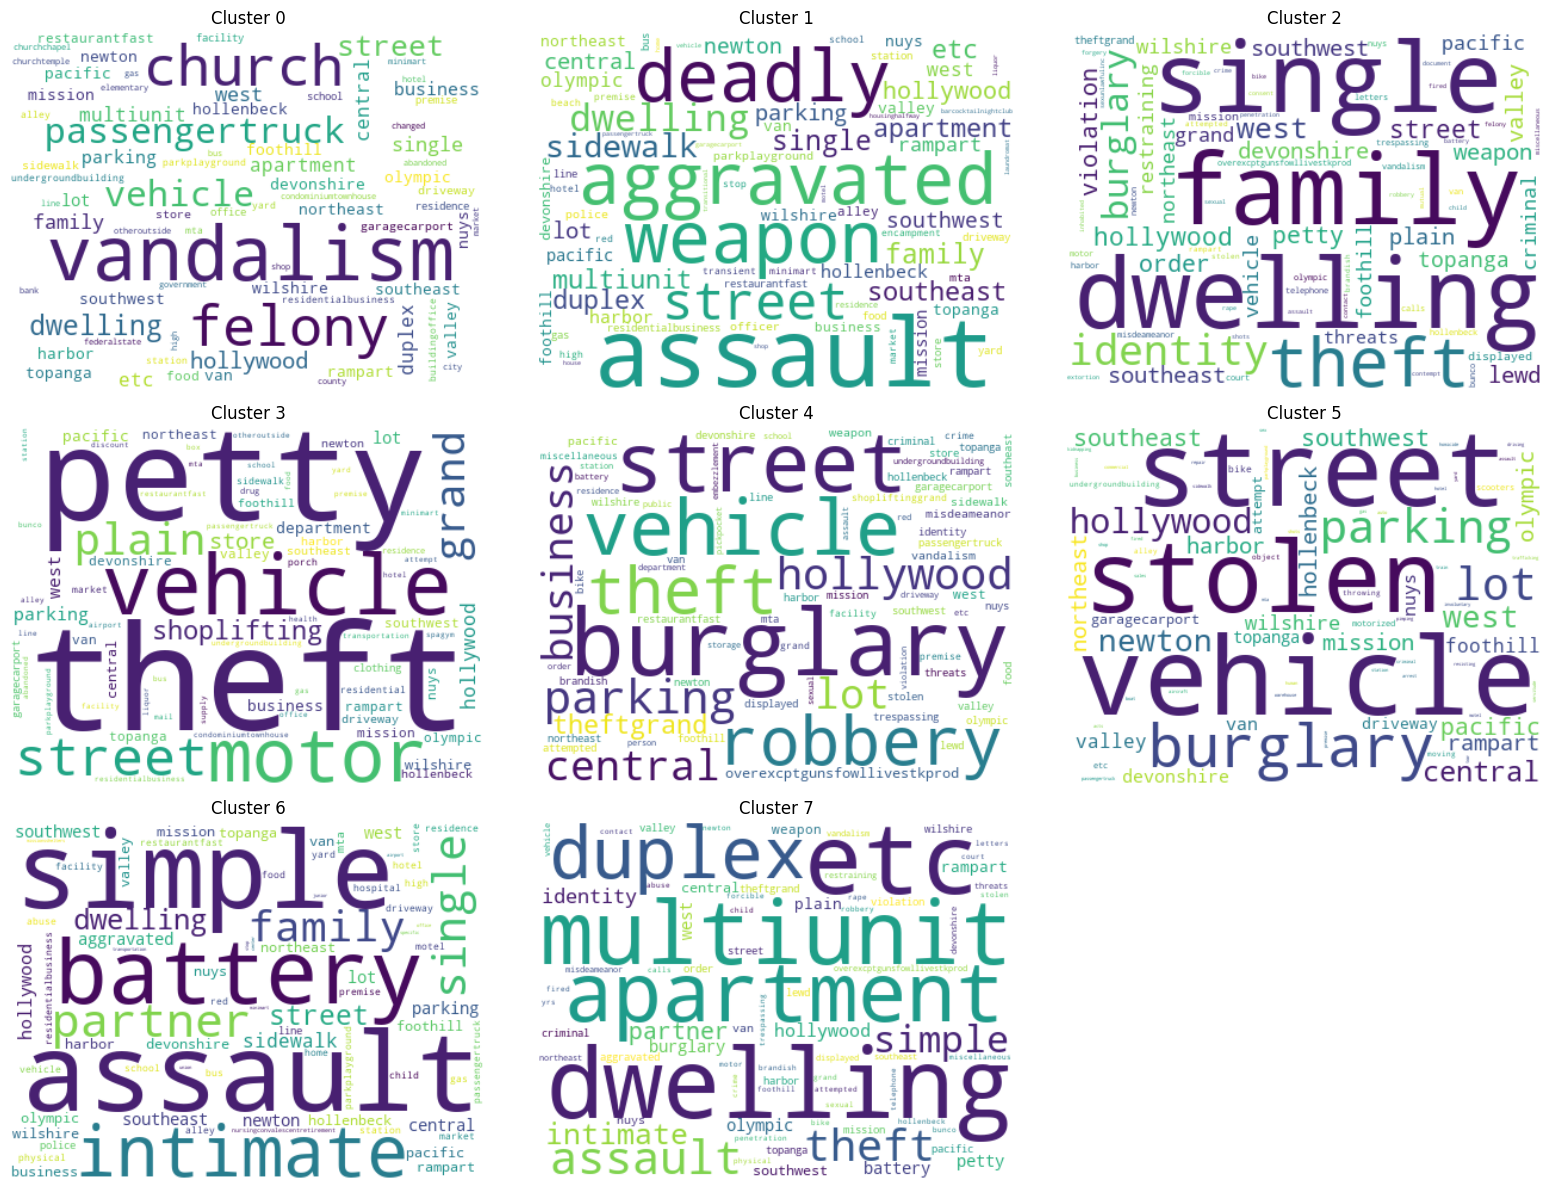

In [34]:
df_with_clusters_crime = df_crime_data.copy()
cluster_text = {}
for cluster_id in df_with_clusters_crime['cluster'].unique():
    cluster_posts = df_with_clusters_crime[df_with_clusters_crime['cluster'] == cluster_id]
    cluster_text[cluster_id] = ' '.join([preprocess_text(text) for text in cluster_posts['text']])


plt.figure(figsize=(12, 8))


clusters = sorted(cluster_text.keys())
rows, cols = (len(clusters) + 2) // 3, min(3, len(clusters))  

fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
if rows == 1 and cols == 1:
    axes = np.array([axes])  
axes = axes.flatten()


for i, cluster_id in enumerate(clusters):
    if i < len(axes):  
        if len(cluster_text[cluster_id]) > 10:  
            wc = WordCloud(
                width=400, height=300,
                background_color='white',
                max_words=75,
                colormap=f'viridis',
                collocations=False,
                random_state=42
            ).generate(cluster_text[cluster_id])
            
            axes[i].imshow(wc, interpolation='bilinear')
            axes[i].set_title(f'Cluster {cluster_id}')
            axes[i].axis('off')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

Los clusters dividen el crimen no solo por ubicación, sino por el tipo de delito y su contexto físico, lo cual puede ser clave para estrategias de seguridad diferenciadas por zona.

### **Exploración y limpieza de datos: Dataset de negocios**

Observamos como se ve el DF

In [35]:
df_Businesses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1607924 entries, 0 to 1607923
Data columns (total 16 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   LOCATION ACCOUNT #         1607924 non-null  object 
 1   BUSINESS NAME              1607924 non-null  object 
 2   DBA NAME                   246256 non-null   object 
 3   STREET ADDRESS             1607822 non-null  object 
 4   CITY                       1607814 non-null  object 
 5   ZIP CODE                   1607924 non-null  object 
 6   LOCATION DESCRIPTION       1607801 non-null  object 
 7   MAILING ADDRESS            369932 non-null   object 
 8   MAILING CITY               369944 non-null   object 
 9   MAILING ZIP CODE           369813 non-null   object 
 10  NAICS                      628889 non-null   float64
 11  PRIMARY NAICS DESCRIPTION  628889 non-null   object 
 12  COUNCIL DISTRICT           1607924 non-null  int64  
 13  LOCATION STA

In [36]:
df_Businesses.head()

LOCATION ACCOUNT #                  BUSINESS NAME             DBA NAME  \
0  0003217523-0001-2             MARIA OFELIA NUNEZ  LA CAMPANA HARDWARE   
1  0003211603-0001-0   ONE STOP HOLISTIC HEALTH LLC                  NaN   
2  0003249387-0001-0                 CHOE SHOW, LLC                  NaN   
3  0003240128-0001-1  SANTOS ANTONIO RAMOS AJPACAJA                  NaN   
4  0003236037-0001-9               ASHLEY-ANN FELIX                  NaN   

             STREET ADDRESS         CITY    ZIP CODE  \
0        1017 W 88TH STREET  LOS ANGELES  90044-2119   
1  1506 W MANCHESTER AVENUE  LOS ANGELES  90047-5424   
2      711 S GRAMERCY PLACE  LOS ANGELES  90005-3166   
3      19948 SATICOY STREET     WINNETKA  91306-2648   
4          412 W 7TH STREET    SAN PEDRO  90731-3208   

       LOCATION DESCRIPTION           MAILING ADDRESS MAILING CITY  \
0           1017 88TH 90044        1017 W 88TH STREET  LOS ANGELES   
1     1506 MANCHESTER 90047  1506 W MANCHESTER AVENUE  LOS ANGELES   
2        711 GRAMERCY 90005      711 S GRAMERCY PLACE  LOS ANGELES   
3  19948 Saticoy 91306-2648                       NaN          NaN   
4             412 7TH 90731      465 N HANFORD AVENUE    SAN PEDRO   

  MAILING ZIP CODE     NAICS                PRIMARY NAICS DESCRIPTION  \
0       90044-2119  444130.0                          Hardware stores   
1       90047-5424       NaN                                      NaN   
2       90005-3166       NaN                                      NaN   
3              NaN  561790.0  Other services to buildings & dwellings   
4       90732-2621       NaN                                      NaN   

   COUNCIL DISTRICT LOCATION START DATE LOCATION END DATE  \
0                 0          10/01/2020               NaN   
1                 8          09/03/2020               NaN   
2                 5          03/15/2021               NaN   
3                 3          01/15/2019               NaN   
4                15          03/01/2021               NaN   

               LOCATION  
0  (33.9581, -118.2926)  
1  (33.9597, -118.3028)  
2  (34.0594, -118.3135)  
3  (34.2081, -118.5684)  
4   (33.738, -118.2861)

#### **Manejo de variables de fecha**

In [37]:
fechas_str = df_Businesses['LOCATION END DATE'].astype(str)
años_validos = fechas_str.str[-4:].where(fechas_str.str[-4:].str.isnumeric()).dropna().astype(int)


In [38]:
filtrar_sospechosas = fechas_str[años_validos[años_validos >= 2026].index]
print(filtrar_sospechosas)


339002    05/01/7987
389942    07/22/7989
393444    03/28/3006
468082    07/02/2030
Name: LOCATION END DATE, dtype: object


In [39]:
df_Businesses = df_Businesses.drop(filtrar_sospechosas.index)

In [40]:
df_Businesses['LOCATION START DATE'] = pd.to_datetime(df_Businesses['LOCATION START DATE'], format= '%m/%d/%Y')
df_Businesses['LOCATION END DATE'] = pd.to_datetime(df_Businesses['LOCATION END DATE'], format= '%m/%d/%Y')

In [41]:
df_Businesses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1607920 entries, 0 to 1607923
Data columns (total 16 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   LOCATION ACCOUNT #         1607920 non-null  object        
 1   BUSINESS NAME              1607920 non-null  object        
 2   DBA NAME                   246255 non-null   object        
 3   STREET ADDRESS             1607818 non-null  object        
 4   CITY                       1607810 non-null  object        
 5   ZIP CODE                   1607920 non-null  object        
 6   LOCATION DESCRIPTION       1607797 non-null  object        
 7   MAILING ADDRESS            369931 non-null   object        
 8   MAILING CITY               369943 non-null   object        
 9   MAILING ZIP CODE           369812 non-null   object        
 10  NAICS                      628887 non-null   float64       
 11  PRIMARY NAICS DESCRIPTION  628887 non-null

#### **Limpieza de datos**

In [42]:
df_Businesses.isnull().sum()/df_Businesses.shape[0] * 100

LOCATION ACCOUNT #            0.000000
BUSINESS NAME                 0.000000
DBA NAME                     84.684872
STREET ADDRESS                0.006344
CITY                          0.006841
ZIP CODE                      0.000000
LOCATION DESCRIPTION          0.007650
MAILING ADDRESS              76.993196
MAILING CITY                 76.992450
MAILING ZIP CODE             77.000597
NAICS                        60.888166
PRIMARY NAICS DESCRIPTION    60.888166
COUNCIL DISTRICT              0.000000
LOCATION START DATE           0.096895
LOCATION END DATE            37.148179
LOCATION                     58.348114
dtype: float64

In [43]:
df_Businesses.drop(columns=['DBA NAME'], inplace=True)

In [44]:
columnas_texto_businesses= ['STREET ADDRESS', 'CITY', 'LOCATION DESCRIPTION', 'MAILING ADDRESS', 'MAILING CITY', 'MAILING ZIP CODE', 'NAICS','PRIMARY NAICS DESCRIPTION', 'LOCATION START DATE', 'LOCATION END DATE', 'LOCATION']
df_Businesses[columnas_texto_businesses] = df_Businesses[columnas_texto_businesses].fillna('')

In [45]:
df_Businesses.isnull().sum()/df_Businesses.shape[0] * 100

LOCATION ACCOUNT #            0.000000
BUSINESS NAME                 0.000000
STREET ADDRESS                0.000000
CITY                          0.000000
ZIP CODE                      0.000000
LOCATION DESCRIPTION          0.000000
MAILING ADDRESS               0.000000
MAILING CITY                  0.000000
MAILING ZIP CODE              0.000000
NAICS                         0.000000
PRIMARY NAICS DESCRIPTION     0.000000
COUNCIL DISTRICT              0.000000
LOCATION START DATE           0.096895
LOCATION END DATE            37.148179
LOCATION                      0.000000
dtype: float64

#### **Manejo de variables geoespaciales**

In [46]:
df_Businesses['LOCATION'].dropna().head(10)

0    (33.9581, -118.2926)
1    (33.9597, -118.3028)
2    (34.0594, -118.3135)
3    (34.2081, -118.5684)
4     (33.738, -118.2861)
5    (34.1031, -118.3485)
6    (33.9562, -118.2963)
7    (34.1135, -118.1505)
8                        
9    (34.1364, -118.2066)
Name: LOCATION, dtype: object

In [47]:
df_Businesses['LAT'] = df_Businesses['LOCATION'].str.extract(r'\(([^,]+),')[0].astype(float)
df_Businesses['LON'] = df_Businesses['LOCATION'].str.extract(r',\s*([^)]+)\)')[0].astype(float)

In [48]:
df_la = df_Businesses[df_Businesses['CITY'].str.upper().str.strip().str.contains('LOS ANGELES', na=False)].copy()
df_la

LOCATION ACCOUNT #                 BUSINESS NAME  \
0        0003217523-0001-2            MARIA OFELIA NUNEZ   
1        0003211603-0001-0  ONE STOP HOLISTIC HEALTH LLC   
2        0003249387-0001-0                CHOE SHOW, LLC   
5        0003206130-0001-6                FRESH AIR HVAC   
6        0003227519-0001-2       H2ORGANICS PRODUCTS INC   
...                    ...                           ...   
1607909  0002447752-0001-1              VORTEX MEDIA LLC   
1607913  0003310793-0001-9                  KARLA Y NEAL   
1607914  0003469025-0001-8    DOMINIC MOISES PUAC MENCHU   
1607916  0003191077-0001-0    CLARISSE KHRISELLE STOCKER   
1607921  0002766738-0001-2             SARAH FITZSIMMONS   

                        STREET ADDRESS         CITY    ZIP CODE  \
0                   1017 W 88TH STREET  LOS ANGELES  90044-2119   
1             1506 W MANCHESTER AVENUE  LOS ANGELES  90047-5424   
2                 711 S GRAMERCY PLACE  LOS ANGELES  90005-3166   
5        7270 FRANKLIN AVENUE APT #105  LOS ANGELES  90046-3057   
6                   1205 W 90TH STREET  LOS ANGELES  90044-2029   
...                                ...          ...         ...   
1607909              1063 SELBY AVENUE  LOS ANGELES  90024-3105   
1607913             4217 DALTON AVENUE  LOS ANGELES  90062-1809   
1607914      4400 S BROADWAY SUITE #02  LOS ANGELES  90037-2791   
1607916            746 N DILLON STREET  LOS ANGELES  90026-3607   
1607921         2350 GREENFIELD AVENUE  LOS ANGELES  90064-1908   

               LOCATION DESCRIPTION           MAILING ADDRESS MAILING CITY  \
0                   1017 88TH 90044        1017 W 88TH STREET  LOS ANGELES   
1             1506 MANCHESTER 90047  1506 W MANCHESTER AVENUE  LOS ANGELES   
2                711 GRAMERCY 90005      711 S GRAMERCY PLACE  LOS ANGELES   
5          7270 Franklin 90046-3057                                          
6                         1205 90TH                                          
...                             ...                       ...          ...   
1607909       1063 SELBY 90024-3105         1063 SELBY AVENUE  LOS ANGELES   
1607913      4217 Dalton 90062-1809                                          
1607914    4400 Broadway 90037-2791         141 W 45TH STREET  LOS ANGELES   
1607916       746 Dillon 90026-3607                                          
1607921  2350 GREENFIELD 90064-1908                                          

        MAILING ZIP CODE     NAICS  \
0             90044-2119  444130.0   
1             90047-5424             
2             90005-3166             
5                         235110.0   
6                         425120.0   
...                  ...       ...   
1607909       90024-3105  541600.0   
1607913                   621610.0   
1607914       90037-2796  812990.0   
1607916                              
1607921                              

                                 PRIMARY NAICS DESCRIPTION  COUNCIL DISTRICT  \
0                                          Hardware stores                 0   
1                                                                          8   
2                                                                          5   
5        Plumbing, Heating, and Air-Conditioning Contra...                 4   
6                         Wholesale trade agents & brokers                 0   
...                                                    ...               ...   
1607909  Management, scientific, & technical consulting...                 5   
1607913                          Home health care services                 8   
1607914                        All other personal services                 9   
1607916                                                                   13   
1607921                                                                    5   

        LOCATION START DATE LOCATION END DATE              LOCATION      LAT  \
0                2020-10-01               NaT  

Text(0.5, 1.0, 'Ubicación de crímenes en LA')

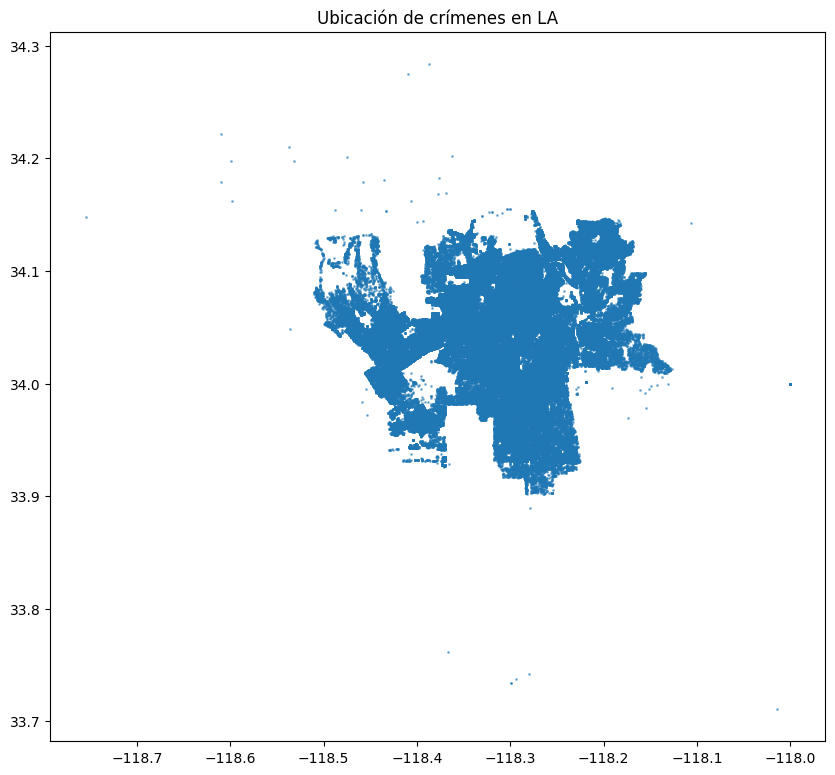

In [49]:
df_la = df_la[df_la['LOCATION'].notnull()]

# 3. Extraer LAT y LON
df_la['LAT'] = df_la['LOCATION'].str.extract(r'\(([^,]+),')[0].astype(float)
df_la['LON'] = df_la['LOCATION'].str.extract(r',\s*([^)]+)\)')[0].astype(float)

df_la = df_la[
    (df_la['LAT'] >= 33.5) & (df_la['LAT'] <= 34.3) &
    (df_la['LON'] >= -119) & (df_la['LON'] <= -117.5)]

# 4. Corregir coordenadas volteadas (si LAT < -100 o LON > 0)
mask = (df_la['LAT'] < -100) & (df_la['LON'] > 0)
df_la.loc[mask, ['LAT', 'LON']] = df_la.loc[mask, ['LON', 'LAT']].values

# 5. Crear geometría
df_la['geometry'] = df_la.apply(lambda row: Point(row['LON'], row['LAT']), axis=1)

# 6. GeoDataFrame con CRS definido
gdf_la = gpd.GeoDataFrame(df_la, geometry='geometry', crs='EPSG:4326')

# 7. Mapa solo con L.A.
gdf_la.plot(figsize=(10, 10), alpha=0.5, markersize=1)

plt.title("Ubicación de crímenes en LA")

In [50]:
gdf_la

LOCATION ACCOUNT #                       BUSINESS NAME  \
0        0003217523-0001-2                  MARIA OFELIA NUNEZ   
1        0003211603-0001-0        ONE STOP HOLISTIC HEALTH LLC   
2        0003249387-0001-0                      CHOE SHOW, LLC   
5        0003206130-0001-6                      FRESH AIR HVAC   
6        0003227519-0001-2             H2ORGANICS PRODUCTS INC   
...                    ...                                 ...   
1607905  0003159837-0001-3  CHRISTIAN MANAGEMENT SERVICES, LLC   
1607907  0002488772-0001-1             VERMONT CARE CENTER INC   
1607909  0002447752-0001-1                    VORTEX MEDIA LLC   
1607913  0003310793-0001-9                        KARLA Y NEAL   
1607914  0003469025-0001-8          DOMINIC MOISES PUAC MENCHU   

                             STREET ADDRESS         CITY    ZIP CODE  \
0                        1017 W 88TH STREET  LOS ANGELES  90044-2119   
1                  1506 W MANCHESTER AVENUE  LOS ANGELES  90047-5424   
2                      711 S GRAMERCY PLACE  LOS ANGELES  90005-3166   
5             7270 FRANKLIN AVENUE APT #105  LOS ANGELES  90046-3057   
6                        1205 W 90TH STREET  LOS ANGELES  90044-2029   
...                                     ...          ...         ...   
1607905  13101 W WASHINGTON BLVD SUITE #215  LOS ANGELES  90066-5173   
1607907               1316 S VERMONT AVENUE  LOS ANGELES  90006-4502   
1607909                   1063 SELBY AVENUE  LOS ANGELES  90024-3105   
1607913                  4217 DALTON AVENUE  LOS ANGELES  90062-1809   
1607914           4400 S BROADWAY SUITE #02  LOS ANGELES  90037-2791   

                LOCATION DESCRIPTION           MAILING ADDRESS MAILING CITY  \
0                    1017 88TH 90044        1017 W 88TH STREET  LOS ANGELES   
1              1506 MANCHESTER 90047  1506 W MANCHESTER AVENUE  LOS ANGELES   
2                 711 GRAMERCY 90005      711 S GRAMERCY PLACE  LOS ANGELES   
5           7270 Franklin 90046-3057                                          
6                          1205 90TH                                          
...                              ...                       ...          ...   
1607905  13101 Washington 90066-5173        28305 N BRUCE ROAD    CHATTAROY   
1607907      1316 VERMONT 90006-4502     1316 S VERMONT AVENUE  LOS ANGELES   
1607909        1063 SELBY 90024-3105         1063 SELBY AVENUE  LOS ANGELES   
1607913       4217 Dalton 90062-1809                                          
1607914     4400 Broadway 90037-2791         141 W 45TH STREET  LOS ANGELES   

        MAILING ZIP CODE     NAICS  \
0             90044-2119  444130.0   
1             90047-5424             
2             90005-3166             
5                         235110.0   
6                         425120.0   
...                  ...       ...   
1607905       99003-9755  541219.0   
1607907       90006-4502  623312.0   
1607909       90024-3105  541600.0   
1607913                   621610.0   
1607914       90037-2796  812990.0   

                                 PRIMARY NAICS DESCRIPTION  COUNCIL DISTRICT  \
0                                          Hardware stores                 0   
1                                                                          8   
2                                                                          5   
5        Plumbing, Heating, and Air-Conditioning Contra...                 4   
6                         Wholesale trade agents & brokers                 0   
...                                                    ...               ...   
1607905                          Other accounting services                 0   
1607907         Assisted Living Facilities for the Elderly                 1   
1607909  Management, scientific, & technical consulting...                 5   
1607913                          Home health care services                 8   
1607914                        All other personal services      

In [51]:
gdf_business_with_neigh = gpd.sjoin(
    gdf_la,
    gdf_areaxvecindario[['name', 'geometry']],
    how="left",
    predicate="within"
)


In [52]:
business_counts = gdf_business_with_neigh.groupby('name').size().reset_index(name='total_negocios')


In [53]:
gdf_neigh_business = gdf_areaxvecindario.merge(business_counts, on='name', how='left').fillna(0)


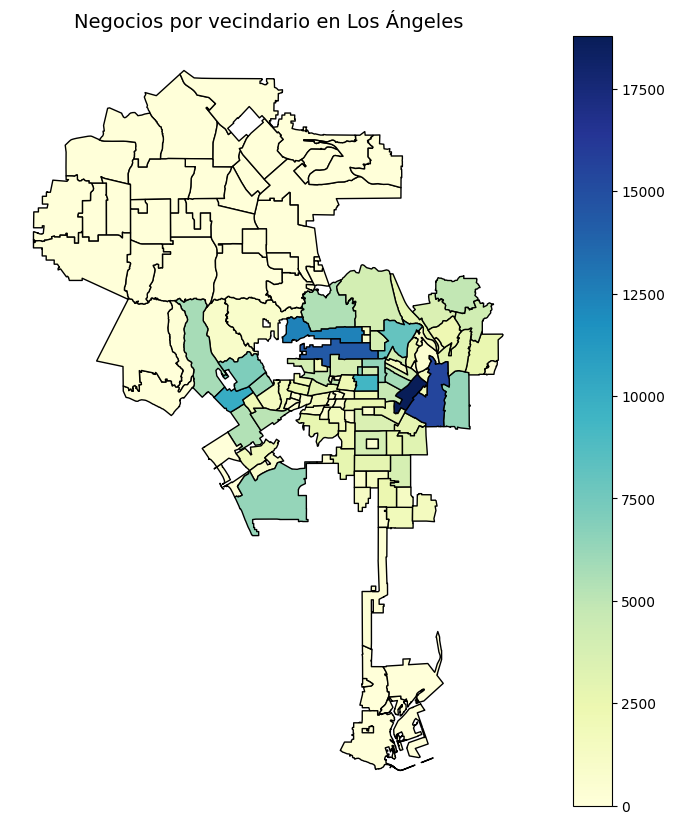

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

gdf_neigh_business.plot(
    column='total_negocios',
    cmap='YlGnBu',
    legend=True,
    edgecolor='black',
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "Sin datos"}
)

plt.title("Negocios por vecindario en Los Ángeles", fontsize=14)
ax.axis('off')
plt.show()


#### **Manejo de variables categóricas (texto)**

In [55]:
df_Businesses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1607920 entries, 0 to 1607923
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   LOCATION ACCOUNT #         1607920 non-null  object        
 1   BUSINESS NAME              1607920 non-null  object        
 2   STREET ADDRESS             1607920 non-null  object        
 3   CITY                       1607920 non-null  object        
 4   ZIP CODE                   1607920 non-null  object        
 5   LOCATION DESCRIPTION       1607920 non-null  object        
 6   MAILING ADDRESS            1607920 non-null  object        
 7   MAILING CITY               1607920 non-null  object        
 8   MAILING ZIP CODE           1607920 non-null  object        
 9   NAICS                      1607920 non-null  object        
 10  PRIMARY NAICS DESCRIPTION  1607920 non-null  object        
 11  COUNCIL DISTRICT           1607920 non-nul

In [56]:
df_Businesses['text'] = (
    df_Businesses['MAILING ADDRESS'].astype(str) + ' ' +
    df_Businesses['STREET ADDRESS'].astype(str) + ' ' +
    df_Businesses['PRIMARY NAICS DESCRIPTION'].astype(str) + ' ' +
    df_Businesses['LOCATION DESCRIPTION'].astype(str)
)

In [57]:
df_Businesses.head()

LOCATION ACCOUNT #                  BUSINESS NAME            STREET ADDRESS  \
0  0003217523-0001-2             MARIA OFELIA NUNEZ        1017 W 88TH STREET   
1  0003211603-0001-0   ONE STOP HOLISTIC HEALTH LLC  1506 W MANCHESTER AVENUE   
2  0003249387-0001-0                 CHOE SHOW, LLC      711 S GRAMERCY PLACE   
3  0003240128-0001-1  SANTOS ANTONIO RAMOS AJPACAJA      19948 SATICOY STREET   
4  0003236037-0001-9               ASHLEY-ANN FELIX          412 W 7TH STREET   

          CITY    ZIP CODE      LOCATION DESCRIPTION  \
0  LOS ANGELES  90044-2119           1017 88TH 90044   
1  LOS ANGELES  90047-5424     1506 MANCHESTER 90047   
2  LOS ANGELES  90005-3166        711 GRAMERCY 90005   
3     WINNETKA  91306-2648  19948 Saticoy 91306-2648   
4    SAN PEDRO  90731-3208             412 7TH 90731   

            MAILING ADDRESS MAILING CITY MAILING ZIP CODE     NAICS  \
0        1017 W 88TH STREET  LOS ANGELES       90044-2119  444130.0   
1  1506 W MANCHESTER AVENUE  LOS ANGELES       90047-5424             
2      711 S GRAMERCY PLACE  LOS ANGELES       90005-3166             
3                                                          561790.0   
4      465 N HANFORD AVENUE    SAN PEDRO       90732-2621             

                 PRIMARY NAICS DESCRIPTION  COUNCIL DISTRICT  \
0                          Hardware stores                 0   
1                                                          8   
2                                                          5   
3  Other services to buildings & dwellings                 3   
4                                                         15   

  LOCATION START DATE LOCATION END DATE              LOCATION      LAT  \
0          2020-10-01               NaT  (33.9581, -118.2926)  33.9581   
1          2020-09-03               NaT  (33.9597, -118.3028)  33.9597   
2          2021-03-15               NaT  (34.0594, -118.3135)  34.0594   
3          2019-01-15               NaT  (34.2081, -118.5684)  34.2081   
4          2021-03-01               NaT   (33.738, -118.2861)  33.7380   

        LON                                               text  
0 -118.2926  1017 W 88TH STREET 1017 W 88TH STREET Hardware...  
1 -118.3028  1506 W MANCHESTER AVENUE 1506 W MANCHESTER AVE...  
2 -118.3135  711 S GRAMERCY PLACE 711 S GRAMERCY PLACE  711...  
3 -118.5684   19948 SATICOY STREET Other services to buildi...  
4 -118.2861  465 N HANFORD AVENUE 412 W 7TH STREET  412 7TH...

In [58]:
df_Businesses["preprocessed_texts"] = [preprocess_text(text) for text in df_Businesses['text']]

In [59]:
tfidf = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.85)

In [60]:
tfidf_matrix_businesses = tfidf.fit_transform(df_Businesses["preprocessed_texts"])

In [61]:
svd_businesses = TruncatedSVD(n_components=100, random_state=42)
embeddings = svd_businesses.fit_transform(tfidf_matrix_businesses)

embeddings = normalize(embeddings)
        
explained_variance_businesses = svd_businesses.explained_variance_ratio_.sum()
print(f"Porcentaje de varianza explicada: {explained_variance_businesses:.2%}")

Porcentaje de varianza explicada: 44.15%


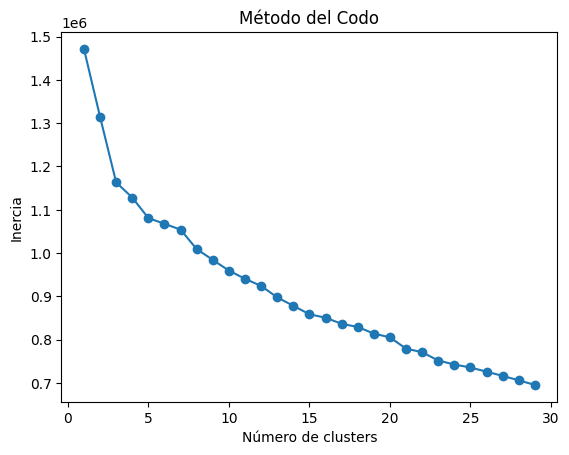

In [62]:
inertia = []
k_range = range(1, 30)
for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(embeddings)
    inertia.append(model.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

Observamos 3 clusters optimos para esta informacion

In [63]:
clustering_df_businesses = KMeans(n_clusters = 3, random_state=42, n_init=10)
clusters_df_businesses = clustering_df_businesses.fit_predict(embeddings)

df_Businesses["cluster"] = clusters_df_businesses

In [64]:
df_Businesses.head()

LOCATION ACCOUNT #                  BUSINESS NAME            STREET ADDRESS  \
0  0003217523-0001-2             MARIA OFELIA NUNEZ        1017 W 88TH STREET   
1  0003211603-0001-0   ONE STOP HOLISTIC HEALTH LLC  1506 W MANCHESTER AVENUE   
2  0003249387-0001-0                 CHOE SHOW, LLC      711 S GRAMERCY PLACE   
3  0003240128-0001-1  SANTOS ANTONIO RAMOS AJPACAJA      19948 SATICOY STREET   
4  0003236037-0001-9               ASHLEY-ANN FELIX          412 W 7TH STREET   

          CITY    ZIP CODE      LOCATION DESCRIPTION  \
0  LOS ANGELES  90044-2119           1017 88TH 90044   
1  LOS ANGELES  90047-5424     1506 MANCHESTER 90047   
2  LOS ANGELES  90005-3166        711 GRAMERCY 90005   
3     WINNETKA  91306-2648  19948 Saticoy 91306-2648   
4    SAN PEDRO  90731-3208             412 7TH 90731   

            MAILING ADDRESS MAILING CITY MAILING ZIP CODE     NAICS  \
0        1017 W 88TH STREET  LOS ANGELES       90044-2119  444130.0   
1  1506 W MANCHESTER AVENUE  LOS ANGELES       90047-5424             
2      711 S GRAMERCY PLACE  LOS ANGELES       90005-3166             
3                                                          561790.0   
4      465 N HANFORD AVENUE    SAN PEDRO       90732-2621             

                 PRIMARY NAICS DESCRIPTION  COUNCIL DISTRICT  \
0                          Hardware stores                 0   
1                                                          8   
2                                                          5   
3  Other services to buildings & dwellings                 3   
4                                                         15   

  LOCATION START DATE LOCATION END DATE              LOCATION      LAT  \
0          2020-10-01               NaT  (33.9581, -118.2926)  33.9581   
1          2020-09-03               NaT  (33.9597, -118.3028)  33.9597   
2          2021-03-15               NaT  (34.0594, -118.3135)  34.0594   
3          2019-01-15               NaT  (34.2081, -118.5684)  34.2081   
4          2021-03-01               NaT   (33.738, -118.2861)  33.7380   

        LON                                               text  \
0 -118.2926  1017 W 88TH STREET 1017 W 88TH STREET Hardware...   
1 -118.3028  1506 W MANCHESTER AVENUE 1506 W MANCHESTER AVE...   
2 -118.3135  711 S GRAMERCY PLACE 711 S GRAMERCY PLACE  711...   
3 -118.5684   19948 SATICOY STREET Other services to buildi...   
4 -118.2861  465 N HANFORD AVENUE 412 W 7TH STREET  412 7TH...   

                                  preprocessed_texts  cluster  
0                      street street hardware stores        1  
1     manchester avenue manchester avenue manchester        0  
2             gramercy place gramercy place gramercy        0  
3  saticoy street services buildings dwellings sa...        0  
4                              hanford avenue street        1

In [65]:
df_with_clusters_businesses = df_Businesses.copy()
    
cluster_stats_businesses = []
    
for cluster_id in range(len(df_with_clusters_businesses['cluster'].unique())):
    cluster_posts = df_with_clusters_businesses[df_with_clusters_businesses['cluster'] == cluster_id]
        
    all_text = ' '.join([preprocess_text(text) for text in cluster_posts['text']])
    words = all_text.split()
    word_freq = pd.Series(words).value_counts()
    top_words = word_freq.head(10).index.tolist()
        
    cluster_stats_businesses.append({
            'cluster_id': cluster_id,
            'post_count': len(cluster_posts),
            'percentage': len(cluster_posts) / len(df_Businesses) * 100,
            'top_words': top_words,
        })
    
cluster_df_businesses = pd.DataFrame(cluster_stats_businesses)

In [66]:
cluster_df_businesses

cluster_id  post_count  percentage  \
0           0     1080090   67.173118   
1           1      245664   15.278372   
2           2      282166   17.548510   

                                           top_words  
0  [blvd, avenue, street, services, suite, drive,...  
1  [street, apt, services, suite, unit, flower, a...  
2  [avenue, apt, services, unit, suite, stars, ta...

<Figure size 1200x800 with 0 Axes>

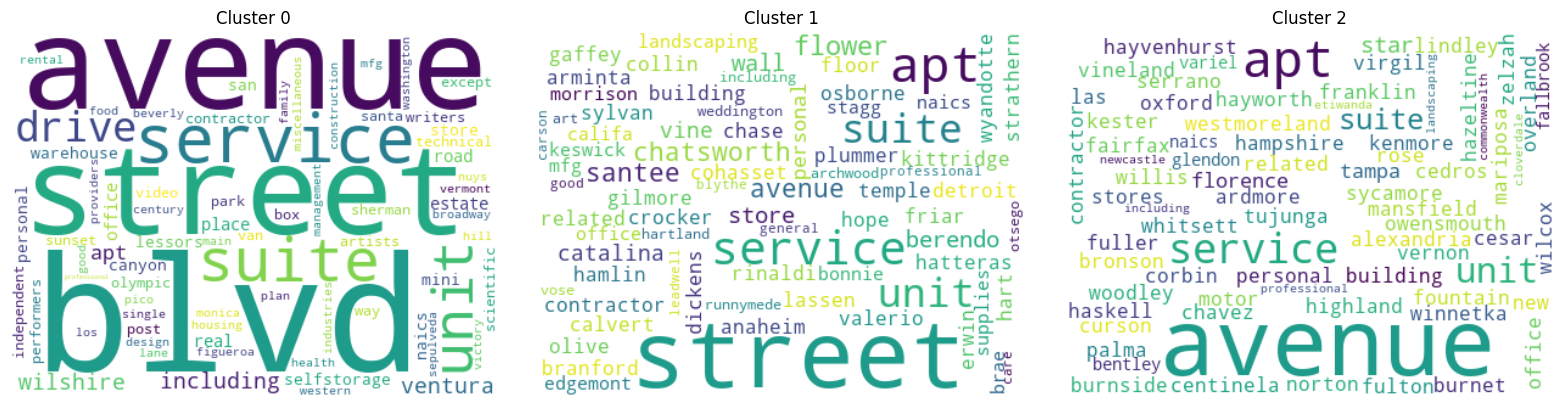

In [67]:
df_with_clusters_businesses = df_Businesses.copy()
cluster_text = {}
for cluster_id in df_with_clusters_businesses['cluster'].unique():
    cluster_posts = df_with_clusters_businesses[df_with_clusters_businesses['cluster'] == cluster_id]
    cluster_text[cluster_id] = ' '.join([preprocess_text(text) for text in cluster_posts['text']])


plt.figure(figsize=(12, 8))


clusters = sorted(cluster_text.keys())
rows, cols = (len(clusters) + 2) // 3, min(3, len(clusters))  

fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
if rows == 1 and cols == 1:
    axes = np.array([axes])  
axes = axes.flatten()


for i, cluster_id in enumerate(clusters):
    if i < len(axes):  
        if len(cluster_text[cluster_id]) > 10:  
            wc = WordCloud(
                width=400, height=300,
                background_color='white',
                max_words=75,
                colormap=f'viridis',
                collocations=False,
                random_state=42
            ).generate(cluster_text[cluster_id])
            
            axes[i].imshow(wc, interpolation='bilinear')
            axes[i].set_title(f'Cluster {cluster_id}')
            axes[i].axis('off')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

Estos clusters no agrupan negocios por giro, sino por su contexto físico y de dirección. Son útiles para entender cómo están distribuidos espacialmente los negocios (tipo de local, forma legal, ubicación), y pueden servir para segmentar zonas con estructura comercial similar.


1. Alta frecuencia de términos genéricos de dirección
>Términos como avenue, street, blvd, suite, unit, service, y apt aparecen fuertemente en todos los clusters. Esto indica que:
>Los negocios registrados en Los Ángeles comparten estructuras comunes de nomenclatura, muy probablemente por dirección comercial o tipo de establecimiento.
>La segmentación por cluster no diferencia por giro comercial, sino por patrones en nombres y ubicaciones.

2. Diferenciación espacial sutil
>Clusters 1 y 2 muestran más nombres específicos de calles como flower, vine, osborne, hayworth, vernon, curson, etc.
>Esto sugiere que los clusters podrían representar zonas o distritos comerciales distintos (por ejemplo: Downtown, el Valle, Hollywood, etc.).

3. Posible agrupación por tipo de infraestructura
Palabras como suite, unit, apt, building, contractor, warehouse indican que hay zonas donde predomina cierta forma de negocio:
>Oficinas
>Servicios técnicos
>Complejos residenciales o comerciales



### **Exploración y limpieza de datos: Dataset de Zillow**

In [68]:
df_housingprices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21628 entries, 0 to 21627
Columns: 312 entries, RegionID to 2025-03-31
dtypes: float64(303), int64(2), object(7)
memory usage: 51.5+ MB


In [69]:
df_housingprices.head()

RegionID  SizeRank         RegionName    RegionType StateName State  \
0    112345         0           Maryvale  neighborhood        AZ    AZ   
1    192689         1           Paradise  neighborhood        NV    NV   
2    270958         2    Upper West Side  neighborhood        NY    NY   
3    270957         3    Upper East Side  neighborhood        NY    NY   
4    118208         4  South Los Angeles  neighborhood        CA    CA   

          City                                  Metro          CountyName  \
0      Phoenix              Phoenix-Mesa-Chandler, AZ     Maricopa County   
1    Las Vegas       Las Vegas-Henderson-Paradise, NV        Clark County   
2     New York  New York-Newark-Jersey City, NY-NJ-PA     New York County   
3     New York  New York-Newark-Jersey City, NY-NJ-PA     New York County   
4  Los Angeles     Los Angeles-Long Beach-Anaheim, CA  Los Angeles County   

      2000-01-31  ...    2024-06-30    2024-07-31    2024-08-31    2024-09-30  \
0   68834.528833  ...  3.487328e+05  3.491530e+05  3.490799e+05  3.483191e+05   
1  133420.548302  ...  3.882462e+05  3.904570e+05  3.921678e+05  3.934213e+05   
2  386532.728587  ...  1.184490e+06  1.188553e+06  1.197697e+06  1.202479e+06   
3  630903.986338  ...  1.172825e+06  1.174627e+06  1.180947e+06  1.184005e+06   
4  131467.995341  ...  6.709993e+05  6.736463e+05  6.789470e+05  6.856306e+05   

     2024-10-31    2024-11-30    2024-12-31    2025-01-31    2025-02-28  \
0  3.471496e+05  3.459533e+05  3.451496e+05  3.440489e+05  3.422023e+05   
1  3.943267e+05  3.954712e+05  3.969703e+05  3.982678e+05  3.987242e+05   
2  1.206483e+06  1.219157e+06  1.237622e+06  1.253386e+06  1.261487e+06   
3  1.185818e+06  1.197299e+06  1.214721e+06  1.229971e+06  1.235865e+06   
4  6.910968e+05  6.948818e+05  6.976291e+05  6.960653e+05  6.910886e+05   

     2025-03-31  
0  3.395317e+05  
1  3.981312e+05  
2  1.265105e+06  
3  1.234522e+06  
4  6.820698e+05  

[5 rows x 312 columns]

#### **Limpieza de datos**

Eliminamos datos inecesarios, por ejemplo otras ciudades y dejamos solamente los angeles

In [70]:
df_crime_data['AREA NAME'] = df_crime_data['AREA NAME'].str.strip().str.upper()

In [71]:
neighborhood_mapping = {
    '77th Street': '77th Street NC',
    'West LA': 'WEST LOS ANGELES',
}

In [72]:
df_housingprices = df_housingprices[df_housingprices['City'] == 'Los Angeles']

In [73]:
columnas_fechas = [col for col in df_housingprices.columns if col.startswith('20')]

df_housing_long = df_housingprices.melt(
    id_vars=['RegionID', 'RegionName', 'RegionType', 'City', 'Metro', 'CountyName'],   
    value_vars=columnas_fechas,      
    var_name='Fecha',
    value_name='Precio'
)

In [74]:
df_housing_long

RegionID             RegionName    RegionType         City  \
0        118208      South Los Angeles  neighborhood  Los Angeles   
1        268496  Southeast Los Angeles  neighborhood  Los Angeles   
2         32059              Hollywood  neighborhood  Los Angeles   
3         46795        North Hollywood  neighborhood  Los Angeles   
4         41466               Van Nuys  neighborhood  Los Angeles   
...         ...                    ...           ...          ...   
29992    417433                 Hermon  neighborhood  Los Angeles   
29993    403194          South Carthay  neighborhood  Los Angeles   
29994     25449         La Tuna Canyon  neighborhood  Los Angeles   
29995    785933           Beverly Glen  neighborhood  Los Angeles   
29996    268144           Elysian Park  neighborhood  Los Angeles   

                                    Metro          CountyName       Fecha  \
0      Los Angeles-Long Beach-Anaheim, CA  Los Angeles County  2000-01-31   
1      Los Angeles-Long Beach-Anaheim, CA  Los Angeles County  2000-01-31   
2      Los Angeles-Long Beach-Anaheim, CA  Los Angeles County  2000-01-31   
3      Los Angeles-Long Beach-Anaheim, CA  Los Angeles County  2000-01-31   
4      Los Angeles-Long Beach-Anaheim, CA  Los Angeles County  2000-01-31   
...                                   ...                 ...         ...   
29992  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County  2025-03-31   
29993  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County  2025-03-31   
29994  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County  2025-03-31   
29995  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County  2025-03-31   
29996  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County  2025-03-31   

             Precio  
0      1.314680e+05  
1      1.151641e+05  
2      2.300735e+05  
3      1.645542e+05  
4      1.370921e+05  
...             ...  
29992  1.012877e+06  
29993  1.916187e+06  
29994  1.282230e+06  
29995  1.488332e+06  
29996  8.651837e+05  

[29997 rows x 8 columns]

In [75]:
df_housing_long['vecindario'] = df_housing_long['RegionName'].str.strip().str.upper()


#### **Manejo de variables de fecha**

In [76]:
df_housing_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29997 entries, 0 to 29996
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    29997 non-null  int64  
 1   RegionName  29997 non-null  object 
 2   RegionType  29997 non-null  object 
 3   City        29997 non-null  object 
 4   Metro       29997 non-null  object 
 5   CountyName  29997 non-null  object 
 6   Fecha       29997 non-null  object 
 7   Precio      29660 non-null  float64
 8   vecindario  29997 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 2.1+ MB


In [77]:
df_housing_long['Fecha'] = pd.to_datetime(df_housing_long['Fecha'])

#### **Manejo de variables categóricas (texto)**

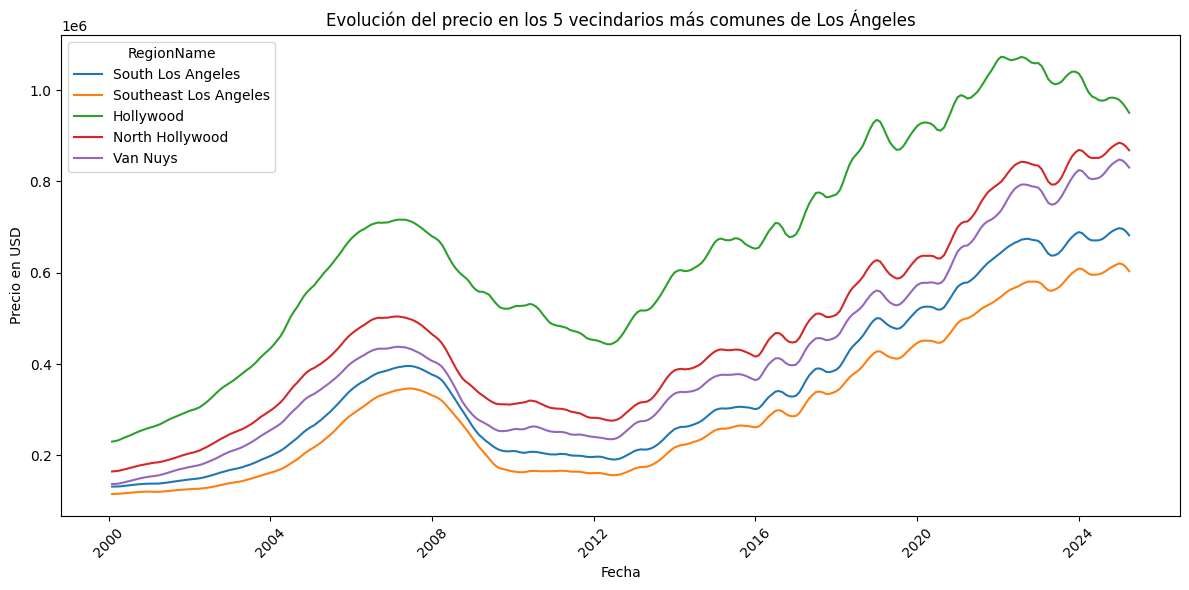

In [78]:
top_vecindarios = df_housing_long['RegionName'].value_counts().head(5).index

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_housing_long[df_housing_long['RegionName'].isin(top_vecindarios)],
             x='Fecha', y='Precio', hue='RegionName')

plt.title('Evolución del precio en los 5 vecindarios más comunes de Los Ángeles')
plt.ylabel('Precio en USD')
plt.xlabel('Fecha')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### **Transformación e integración de datos:**

In [79]:
print(gdf_areaxvecindario.columns)

Index(['objectid', 'name', 'description', 'infographic', 'site_area_type',
       'COMMUNITY', 'Shape__Area', 'Shape__Length', 'geometry'],
      dtype='object')


In [80]:
df_crime = df_crime_data.dropna(subset=['LAT', 'LON'])

df_crime['geometry'] = df_crime.apply(lambda row: Point(row['LON'], row['LAT']), axis=1)
gdf_crime = gpd.GeoDataFrame(df_crime, geometry='geometry', crs='EPSG:4326')

gdf_crime_with_area = gpd.sjoin(gdf_crime, gdf_areaxvecindario[['name', 'geometry']], how='left', predicate='within')

gdf_crime_with_area['vecindario'] = gdf_crime_with_area['name'].str.strip().str.upper()

In [81]:
df_business = df_Businesses.dropna(subset=['LAT', 'LON'])
df_business['geometry'] = df_business.apply(lambda row: Point(row['LON'], row['LAT']), axis=1)
gdf_business = gpd.GeoDataFrame(df_business, geometry='geometry', crs='EPSG:4326')

gdf_business_with_area = gpd.sjoin(gdf_business, gdf_areaxvecindario[['name', 'geometry']], how='left', predicate='within')

In [82]:
df_poblacionxvecindario['NC_Name'] = df_poblacionxvecindario['NC_Name'].str.replace(r'\s+NC$', '', regex=True)
df_poblacionxvecindario 


NC_Name  Total Population  White_pop  Black_pop  \
0                         ARLETA          34932.84    2882.67     409.67   
1                    ARROYO SECO          21711.47    4640.35     782.76   
2                ATWATER VILLAGE          11385.40    3450.70     127.80   
3          BEL AIR-BEVERLY CREST          26789.14   22024.61     349.63   
4                  BOYLE HEIGHTS          81900.56    1562.20     640.97   
..                           ...               ...        ...        ...   
92                    WILMINGTON          59140.55    3840.90    1406.41   
93   WILSHIRE CENTER - KOREATOWN          99702.15    7364.20    3608.43   
94                      WINNETKA          51259.94   12768.80    2713.13   
95  WOODLAND HILLS-WARNER CENTER          68837.33   44685.05    3618.24   
96                   ZAPATA KING          50013.53     596.58    5255.97   

    Ameri_es_pop  Asian_pop  Hawn_pi_pop  Hispanic_pop  Other_pop  Multi_pop  \
0          67.64    4061.31        34.96           NaN      37.58     245.05   
1          89.51    3215.37        25.38           NaN      66.98     263.12   
2           0.15    2379.08        71.85           NaN       0.37     252.76   
3           0.02    1787.79         0.01           NaN     156.92     946.28   
4          63.63    2266.59        73.99           NaN      90.30      98.50   
..           ...        ...          ...           ...        ...        ...   
92        173.57    1203.80       361.61           NaN       9.32     306.10   
93        216.59   32842.25       392.87           NaN     628.59    1025.46   
94        105.84    8204.16        23.63           NaN      42.65    1441.14   
95        236.68    7481.77        55.14           NaN      83.33    2819.34   
96         17.10      51.29        94.88           NaN     211.02     149.12   

    In_Poverty  Owner_occ  Renter_occ  
0     34700.56    5590.27     2159.94  
1     21582.85    4138.14     3235.61  
2     11345.53    1877.30     2902.89  
3     26623.97    8939.21     1943.18  
4     81144.31    4743.28    16001.77  
..         ...        ...         ...  
92    58039.47    6169.10     8086.33  
93    99508.61    2141.05    36026.35  
94    51043.62    7773.78     7369.18  
95    68502.94   15715.69    12213.06  
96    49808.63    2940.07     8463.65  

[97 rows x 13 columns]

In [83]:
renombres = {
    'BEL AIR-BEVERLY CREST': 'BEL AIR',
    'HOLLYWOOD HILLS-WEST': 'HOLLYWOOD HILLS',
   
}

df_poblacionxvecindario['NC_Name'] = df_poblacionxvecindario['NC_Name'].replace(renombres)


In [84]:
df_poblacionxvecindario['NC_Name'] = df_poblacionxvecindario['NC_Name'].str.replace(r'.*HOLLYWOOD.*', 'HOLLYWOOD', regex=True)


In [85]:
df_poblacionxvecindario.head()

NC_Name  Total Population  White_pop  Black_pop  Ameri_es_pop  \
0           ARLETA          34932.84    2882.67     409.67         67.64   
1      ARROYO SECO          21711.47    4640.35     782.76         89.51   
2  ATWATER VILLAGE          11385.40    3450.70     127.80          0.15   
3          BEL AIR          26789.14   22024.61     349.63          0.02   
4    BOYLE HEIGHTS          81900.56    1562.20     640.97         63.63   

   Asian_pop  Hawn_pi_pop  Hispanic_pop  Other_pop  Multi_pop  In_Poverty  \
0    4061.31        34.96           NaN      37.58     245.05    34700.56   
1    3215.37        25.38           NaN      66.98     263.12    21582.85   
2    2379.08        71.85           NaN       0.37     252.76    11345.53   
3    1787.79         0.01           NaN     156.92     946.28    26623.97   
4    2266.59        73.99           NaN      90.30      98.50    81144.31   

   Owner_occ  Renter_occ  
0    5590.27     2159.94  
1    4138.14     3235.61  
2    1877.30     2902.89  
3    8939.21     1943.18  
4    4743.28    16001.77

In [86]:
df_housing_long['vecindario'] = df_housing_long['RegionName'].str.strip().str.upper()
df_poblacionxvecindario['vecindario'] = df_poblacionxvecindario['NC_Name'].str.strip().str.upper()
gdf_crime_with_area['vecindario'] = gdf_crime_with_area['name'].str.strip().str.upper()
gdf_business_with_area['vecindario'] = gdf_business_with_area['name'].str.strip().str.upper()

reemplazos = {
    'CENTRAL SAN PEDRO': 'SAN PEDRO',
    'COASTAL SAN PEDRO': 'SAN PEDRO',
    'NORTHWEST SAN PEDRO': 'SAN PEDRO',
    'NORTHRIDGE EAST': 'NORTHRIDGE',
    'NORTHRIDGE WEST': 'NORTHRIDGE',
    'NORTHRIDGE SOUTH': 'NORTHRIDGE',
    'WOODLAND HILLS-WARNER CENTER': 'WOODLAND HILLS',
    'WILSHIRE CENTER - KOREATOWN': 'KOREATOWN',
    'WESTLAKE NORTH': 'WESTLAKE',
    'WESTLAKE SOUTH': 'WESTLAKE',
    'GREATER VALLEY GLEN COUNCIL': 'VALLEY GLEN',
    'NORTH HILLS EAST': 'NORTH HILLS',
    'NORTH HILLS WEST' : 'NORTH HILLS',
    'SUN VALLEY AREA' : 'SUN VALLEY',
    'GRANADA HILLS NORTH' : 'GRANADA HILLS',
    'GRANADA HILLS SOUTH' : 'GRANADA HILLS',
    'HISTORIC HIGHLAND PARK' : 'HIGHLAND PARK',
    'DOWNTOWN LOS ANGELES': 'DOWNTOWN',
    'HARBOR GATEWAY NORTH' : 'HARBOR GATEWAY',
    'HARBOR GATEWAY SOUTH' : 'HARBOR GATEWAY',
    'MAR VISTA CC' : 'MAR VISTA',
    'NC WESTCHESTER/PLAYA' : 'WESTCHESTER',
    'UNITED NEIGHBORHOODS OF THE HISTORIC ARLINGTON HEIGHTS, WEST ADAMS, AND JEFFERSON PARK COMMUNITY' : 'JEFFERSON PARK',
    'SUNLAND-TUJUNGA' : 'TUJUNGA',
    'NC VALLEY VILLAGE' : 'VALLEY VILLAGE',
    'GREATER ECHO PARK ELYSIAN' : 'ECHO PARK',
    'DEL REY' : 'PLAYA DEL REY',
    'MAR VISTA' : 'PLAYA VISTA',
    'GREATER TOLUCA LAKE' : 'TOLUCA LAKE',
    'ELYSIAN VALLEY RIVERSIDE' : 'ELYSIAN VALLEY',

}

df_poblacionxvecindario['vecindario'] = df_poblacionxvecindario['vecindario'].replace(reemplazos)
df_housing_long['vecindario'] = df_housing_long['vecindario'].replace(reemplazos)
gdf_crime_with_area['vecindario'] = gdf_crime_with_area['vecindario'].replace(reemplazos)
gdf_business_with_area['vecindario'] = gdf_business_with_area['vecindario'].replace(reemplazos)

df_housing_long['vecindario'] = df_housing_long['vecindario'].replace(neighborhood_mapping)

crimen_agg = gdf_crime_with_area.groupby('vecindario').size().reset_index(name='Total Crimenes')
negocios_agg = gdf_business_with_area.groupby('vecindario').size().reset_index(name='Total Negocios')

df_final = df_housing_long.merge(df_poblacionxvecindario[['vecindario', 'Total Population']], on='vecindario', how='left')
df_final = df_final.merge(crimen_agg, on='vecindario', how='left')
df_final = df_final.merge(negocios_agg, on='vecindario', how='left')

print(df_final.head())

   RegionID             RegionName    RegionType         City  \
0    118208      South Los Angeles  neighborhood  Los Angeles   
1    268496  Southeast Los Angeles  neighborhood  Los Angeles   
2     32059              Hollywood  neighborhood  Los Angeles   
3     32059              Hollywood  neighborhood  Los Angeles   
4     32059              Hollywood  neighborhood  Los Angeles   

                                Metro          CountyName      Fecha  \
0  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2000-01-31   
1  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2000-01-31   
2  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2000-01-31   
3  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2000-01-31   
4  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2000-01-31   

          Precio             vecindario  Total Population  Total Crimenes  \
0  131467.995341      SOUTH LOS ANGELES               NaN             NaN   
1  115164.134048  SOUT

In [87]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34239 entries, 0 to 34238
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   RegionID          34239 non-null  int64         
 1   RegionName        34239 non-null  object        
 2   RegionType        34239 non-null  object        
 3   City              34239 non-null  object        
 4   Metro             34239 non-null  object        
 5   CountyName        34239 non-null  object        
 6   Fecha             34239 non-null  datetime64[ns]
 7   Precio            33902 non-null  float64       
 8   vecindario        34239 non-null  object        
 9   Total Population  22119 non-null  float64       
 10  Total Crimenes    27876 non-null  float64       
 11  Total Negocios    27876 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(6)
memory usage: 3.1+ MB


In [88]:
df_final['vecindario'] = df_final['vecindario'].str.strip().str.replace('"', '').str.replace("'", '')


In [89]:
reemplazos = {
    'HOLLYWOOD HILLS': 'HOLLYWOOD',
    'HOLLYWOOD HEIGHTS': 'HOLLYWOOD',
    'WEST HOLLYWOOD': 'HOLLYWOOD',
    'NORTH HOLLYWOOD': 'HOLLYWOOD',
    'HOLLYWOOD': 'HOLLYWOOD'  
}

df_final['vecindario'] = df_final['vecindario'].replace(reemplazos)
df_final['RegionName'] = df_final['RegionName'].replace(reemplazos)

In [90]:
comparacion = df_final['RegionName'].str.strip().str.upper() == df_final['vecindario'].str.strip().str.upper()

diferencias = (~comparacion).sum()
print(f"Cantidad de filas con diferencias: {diferencias}")


Cantidad de filas con diferencias: 1212


In [91]:
df_diferencias = df_final[~comparacion][['RegionName', 'vecindario']]
display(df_diferencias.drop_duplicates())


RegionName     vecindario
9   North Hollywood      HOLLYWOOD
50        Mar Vista    PLAYA VISTA
61          Del Rey  PLAYA DEL REY
62  Hollywood Hills      HOLLYWOOD

In [92]:
df_final['RegionName'] = df_final['RegionName'].replace({
    'North Hollywood': 'Hollywood',
    'Hollywood Hills': 'Hollywood'
})

df_final['vecindario'] = df_final['RegionName'].str.strip().str.upper()

print((df_final['vecindario'] == df_final['RegionName'].str.strip().str.upper()).all())  
df_final.drop(columns='RegionName', inplace=True)


True


In [93]:
df_final


RegionID    RegionType         City  \
0        118208  neighborhood  Los Angeles   
1        268496  neighborhood  Los Angeles   
2         32059  neighborhood  Los Angeles   
3         32059  neighborhood  Los Angeles   
4         32059  neighborhood  Los Angeles   
...         ...           ...          ...   
34234    417433  neighborhood  Los Angeles   
34235    403194  neighborhood  Los Angeles   
34236     25449  neighborhood  Los Angeles   
34237    785933  neighborhood  Los Angeles   
34238    268144  neighborhood  Los Angeles   

                                    Metro          CountyName      Fecha  \
0      Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2000-01-31   
1      Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2000-01-31   
2      Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2000-01-31   
3      Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2000-01-31   
4      Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2000-01-31   
...                                   ...                 ...        ...   
34234  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2025-03-31   
34235  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2025-03-31   
34236  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2025-03-31   
34237  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2025-03-31   
34238  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2025-03-31   

             Precio             vecindario  Total Population  Total Crimenes  \
0      1.314680e+05      SOUTH LOS ANGELES               NaN             NaN   
1      1.151641e+05  SOUTHEAST LOS ANGELES               NaN             NaN   
2      2.300735e+05              HOLLYWOOD          19861.33         33263.0   
3      2.300735e+05              HOLLYWOOD          46533.39         33263.0   
4      2.300735e+05              HOLLYWOOD          38427.16         33263.0   
...             ...                    ...               ...             ...   
34234  1.012877e+06                 HERMON           4395.45             NaN   
34235  1.916187e+06          SOUTH CARTHAY               NaN          2497.0   
34236  1.282230e+06         LA TUNA CANYON               NaN             NaN   
34237  1.488332e+06           BEVERLY GLEN               NaN             NaN   
34238  8.651837e+05           ELYSIAN PARK               NaN          2007.0   

       Total Negocios  
0                 NaN  
1                 NaN  
2             13440.0  
3             13440.0  
4             13440.0  
...               ...  
34234             NaN  
34235          1854.0  
34236             NaN  
34237             NaN  
34238           578.0  

[34239 rows x 11 columns]

In [94]:
df_final['vecindario'] = df_final['vecindario'].str.replace(r'.*HOLLYWOOD.*', 'HOLLYWOOD', regex=True)
df_final['vecindario'] = df_final['vecindario'].str.replace(r'.*BEL AIR.*', 'BEL AIR', regex=True)

In [95]:
df_final = df_final.dropna(subset=['Total Crimenes', 'Total Negocios', 'Total Population'], how='all')

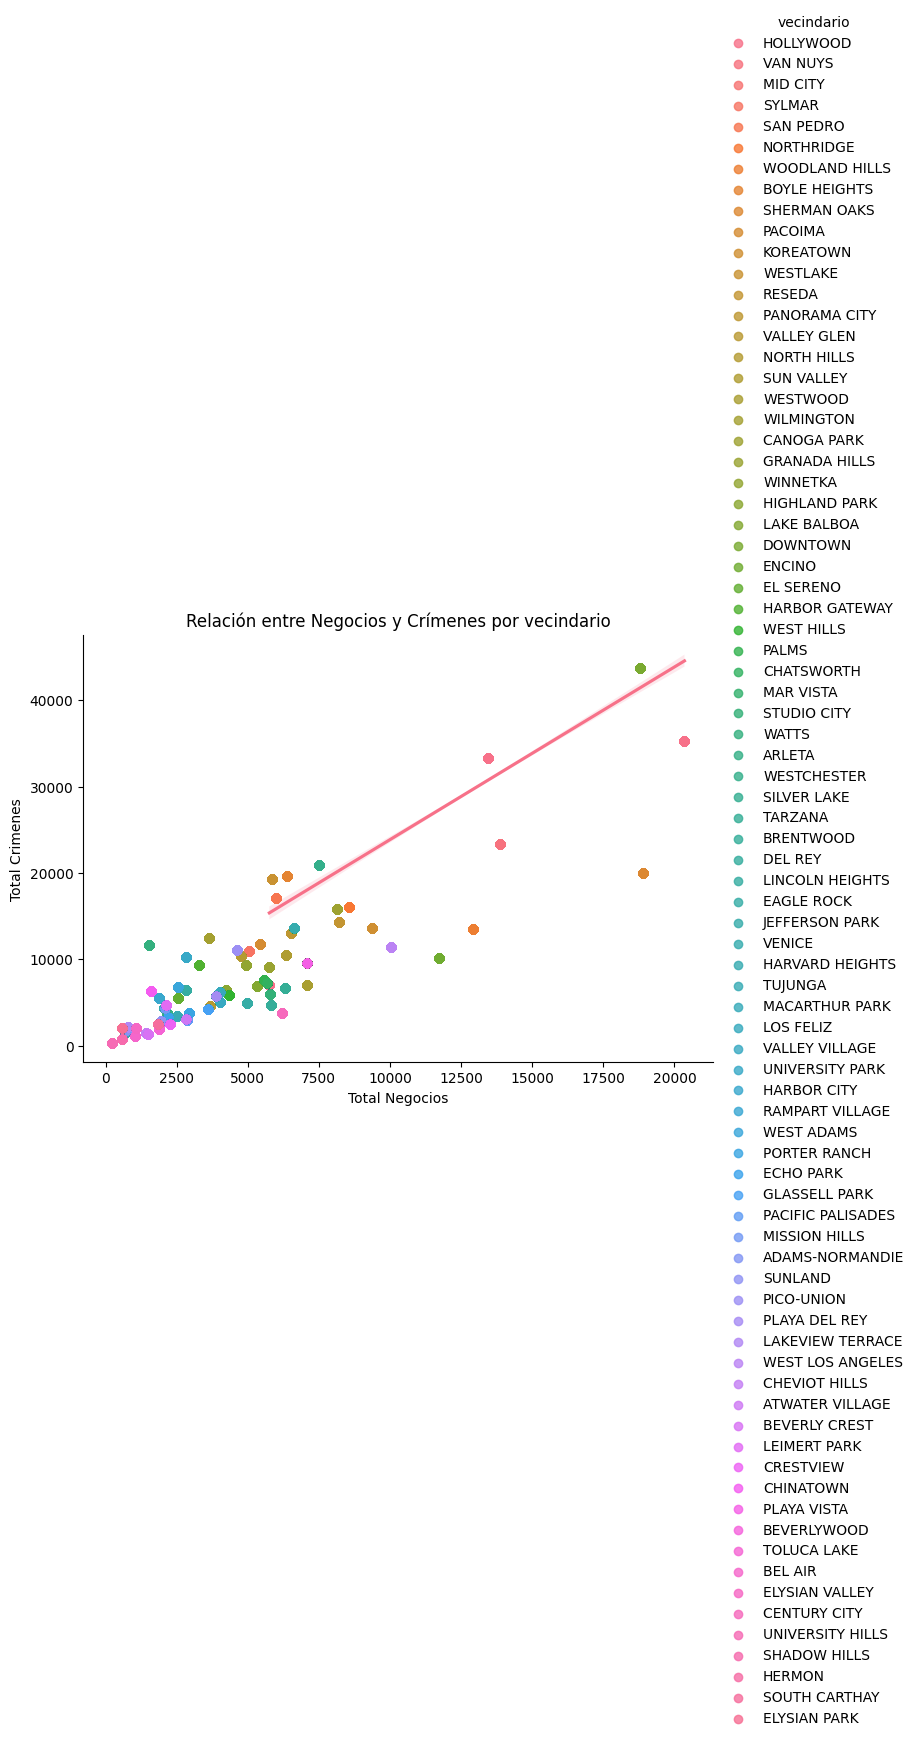

In [ ]:
sns.lmplot(
    data=df_final,
    x='Total Negocios', y='Total Crimenes',
    hue='vecindario', fit_reg=True, aspect=1.5
)
plt.title('Relación entre Negocios y Crímenes por vecindario')
plt.show()


Muestra una tendencia positiva clara: a mayor número de negocios, mayor número de crímenes.

Tiene lógica: más negocios → más actividad económica → más oportunidades de delito.

Vecindarios como HOLLYWOOD y MID CITY están muy por encima del promedio en ambos ejes.

Son puntos clave para análisis individual o posibles outliers.

<Figure size 1200x1000 with 0 Axes>

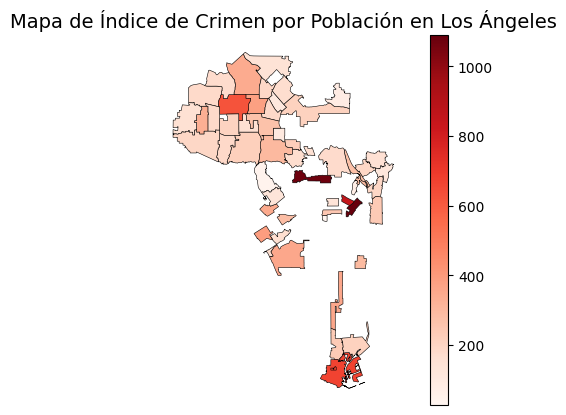

In [97]:
gdf_areaxvecindario['vecindario'] = gdf_areaxvecindario['name'].str.upper()
df_final['vecindario'] = df_final['vecindario'].str.upper()


df_final['Indice Crimen por Poblacion'] = (
    df_final['Total Crimenes'] / df_final['Total Population']
) * 1000

df_crimen_mapa = df_final.groupby('vecindario').mean(numeric_only=True).reset_index()

gdf_merged = gdf_areaxvecindario.merge(df_crimen_mapa, on='vecindario', how='left')

plt.figure(figsize=(12, 10))
gdf_merged.plot(
    column='Indice Crimen por Poblacion',
    cmap='Reds',
    legend=True,
    edgecolor='black',
    linewidth=0.4
)
plt.title("Mapa de Índice de Crimen por Población en Los Ángeles", fontsize=14)
plt.axis('off')
plt.show()


El mapa revela focos críticos de crimen relativo, útiles para priorizar estrategias de seguridad pública, inversión social o políticas urbanas

## **Fase 2**


In [98]:
df_poblacionxvecindario
df_housing_long
gdf_crime_with_area
gdf_business_with_area

LOCATION ACCOUNT #                  BUSINESS NAME  \
0        0003217523-0001-2             MARIA OFELIA NUNEZ   
1        0003211603-0001-0   ONE STOP HOLISTIC HEALTH LLC   
2        0003249387-0001-0                 CHOE SHOW, LLC   
3        0003240128-0001-1  SANTOS ANTONIO RAMOS AJPACAJA   
4        0003236037-0001-9               ASHLEY-ANN FELIX   
...                    ...                            ...   
1607912  0003112677-0001-5           HEADLESS MUSICAL LLC   
1607913  0003310793-0001-9                   KARLA Y NEAL   
1607914  0003469025-0001-8     DOMINIC MOISES PUAC MENCHU   
1607919  0003417591-0001-0          HERITAGE ELECTRIC INC   
1607920  0003341552-0001-0        FESTIVAL HAIR QUEEN LLC   

                          STREET ADDRESS            CITY    ZIP CODE  \
0                     1017 W 88TH STREET     LOS ANGELES  90044-2119   
1               1506 W MANCHESTER AVENUE     LOS ANGELES  90047-5424   
2                   711 S GRAMERCY PLACE     LOS ANGELES  90005-3166   
3                   19948 SATICOY STREET        WINNETKA  91306-2648   
4                       412 W 7TH STREET       SAN PEDRO  90731-3208   
...                                  ...             ...         ...   
1607912          16830 VENTURA BLVD #400          ENCINO  91436-1726   
1607913               4217 DALTON AVENUE     LOS ANGELES  90062-1809   
1607914        4400 S BROADWAY SUITE #02     LOS ANGELES  90037-2791   
1607919  2175 GOODYEAR AVENUE SUITE #109         VENTURA  93003-7761   
1607920               22801 VENTURA BLVD  WOODLAND HILLS  91364-1222   

             LOCATION DESCRIPTION                MAILING ADDRESS MAILING CITY  \
0                 1017 88TH 90044             1017 W 88TH STREET  LOS ANGELES   
1           1506 MANCHESTER 90047       1506 W MANCHESTER AVENUE  LOS ANGELES   
2              711 GRAMERCY 90005           711 S GRAMERCY PLACE  LOS ANGELES   
3        19948 Saticoy 91306-2648                                               
4                   412 7TH 90731           465 N HANFORD AVENUE    SAN PEDRO   
...                           ...                            ...          ...   
1607912  16830 VENTURA 91436-1726  16830 VENTURA BLVD SUITE #400       ENCINO   
1607913    4217 Dalton 90062-1809                                               
1607914  4400 Broadway 90037-2791              141 W 45TH STREET  LOS ANGELES   
1607919  2175 GOODYEAR 93003-7761         223 LUCADA STREET ROOM  SANTA PAULA   
1607920  22801 VENTURA 91364-1222             6427 PINION STREET     OAK PARK   

        MAILING ZIP CODE     NAICS  ...              LOCATION      LAT  \
0             90044-2119  444130.0  ...  (33.9581, -118.2926)  33.9581   
1             90047-5424            ...  (33.9597, -118.3028)  33.9597   
2             90005-3166            ...  (34.0594, -118.3135)  34.0594   
3                         561790.0  ...  (34.2081, -118.5684)  34.2081   
4             90732-2621            ...   (33.738, -118.2861)  33.7380   
...                  ...       ...  ...                   ...      ...   
1607912       91436-1726  711100.0  ...  (34.1586, -118.5008)  34.1586   
1607913                   621610.0  ...  (34.0068, -118.3038)  34.0068   
1607914       90037-2796  812990.0  ...  (34.0035, -118.2779)  34.0035   
1607919            93060  235310.0  ...  (34.2532, -119.2329)  34.2532   
1607920       91377-1210            ...  (34.1662, -118.6236)  34.1662   

              LON                                               text  \
0       -118.2926  1017 W 88TH STREET 1017 W 88TH STREET Hardware...   
1       -118.3028  1506 W MANCHESTER AVENUE 1506 W MANCHESTER AVE...   
2       -118.3135  711 S GRAMERCY PLACE 711 S GRAMERCY PLACE  711...   
3       -118.5684   19948 SATICOY STREET Other services to buildi...   
4       -118.2861  465 N HANFORD AVENUE 412 W 7TH STREET  412 7TH...   
...           ...                                                ...   
1607912 -118.5008  16830 VENTURA BLVD SUITE 

### **Primer KPI**

Índice de Crimen por Población

In [99]:
crimenes_por_vecindario = gdf_crime_with_area['vecindario'].value_counts()

poblacion_vecindario = df_poblacionxvecindario[['vecindario', 'Total Population']].set_index('vecindario')

crimenes_por_vecindario.index = crimenes_por_vecindario.index.str.upper()
poblacion_vecindario.index = poblacion_vecindario.index.str.upper()

datos_merged = poblacion_vecindario.join(crimenes_por_vecindario.rename('Total Crimenes'), how='inner')

datos_merged['Indice Crimen por Poblacion'] = (datos_merged['Total Crimenes'] / datos_merged['Total Population']) * 1000

datos_merged[['Total Crimenes', 'Total Population', 'Indice Crimen por Poblacion']]

Total Crimenes  Total Population  Indice Crimen por Poblacion
vecindario                                                                    
ARLETA                     3832          34932.84                   109.696206
ATWATER VILLAGE            3109          11385.40                   273.069018
BEL AIR                    1164          26789.14                    43.450443
BOYLE HEIGHTS             19688          81900.56                   240.389077
CANOGA PARK               15775          47610.41                   331.335101
...                         ...               ...                          ...
WESTWOOD                   7076          55443.69                   127.624983
WILMINGTON                12497          59140.55                   211.310176
KOREATOWN                 13615          99702.15                   136.556734
WINNETKA                   9349          51259.94                   182.384139
WOODLAND HILLS            13510          68837.33                   196.259791

[67 rows x 3 columns]

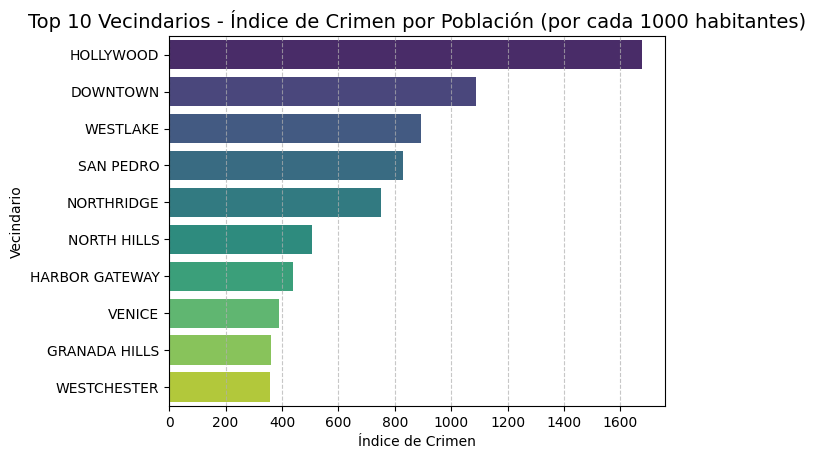

In [100]:
if 'vecindario' not in datos_merged.columns:
	datos_merged = datos_merged.reset_index() 

top10 = datos_merged[['vecindario', 'Indice Crimen por Poblacion']].dropna()
top10 = top10.sort_values('Indice Crimen por Poblacion', ascending=False).drop_duplicates('vecindario').head(10)
sns.barplot(data=top10, x='Indice Crimen por Poblacion', y='vecindario', palette='viridis')


plt.title('Top 10 Vecindarios - Índice de Crimen por Población (por cada 1000 habitantes)', fontsize=14)
plt.xlabel('Índice de Crimen')
plt.ylabel('Vecindario')
plt.grid(axis='x', linestyle='--', alpha=0.7)


### **Segundo KPI**

Porcentaje de propietarios de viviendas por vecindario

In [101]:
df_poblacionxvecindario['Porcentaje Propietarios'] = (df_poblacionxvecindario['Owner_occ'] / df_poblacionxvecindario['Total Population']) * 100
df_poblacionxvecindario[['vecindario', 'Total Population', 'Owner_occ', 'Porcentaje Propietarios']]

vecindario  Total Population  Owner_occ  Porcentaje Propietarios
0            ARLETA          34932.84    5590.27                16.002907
1       ARROYO SECO          21711.47    4138.14                19.059695
2   ATWATER VILLAGE          11385.40    1877.30                16.488661
3           BEL AIR          26789.14    8939.21                33.368783
4     BOYLE HEIGHTS          81900.56    4743.28                 5.791511
..              ...               ...        ...                      ...
92       WILMINGTON          59140.55    6169.10                10.431252
93        KOREATOWN          99702.15    2141.05                 2.147446
94         WINNETKA          51259.94    7773.78                15.165410
95   WOODLAND HILLS          68837.33   15715.69                22.830185
96      ZAPATA KING          50013.53    2940.07                 5.878549

[97 rows x 4 columns]

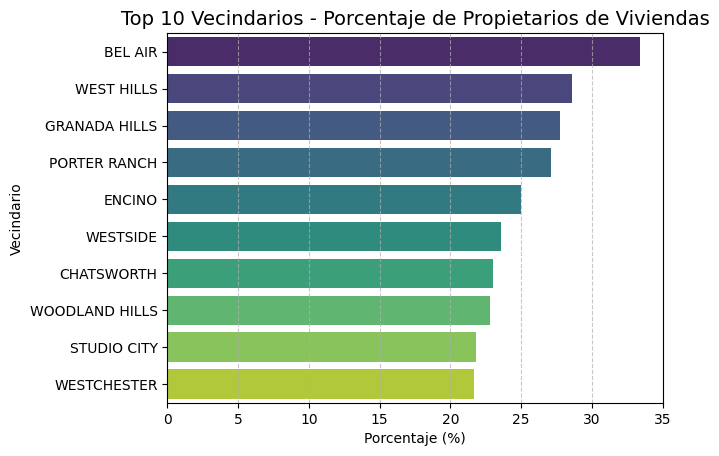

In [102]:
plt.subplot(1, 1, 1)

top10_propietarios = df_poblacionxvecindario[['vecindario', 'Porcentaje Propietarios']].dropna()
top10_propietarios = top10_propietarios.drop_duplicates('vecindario')
top10_propietarios = top10_propietarios.sort_values('Porcentaje Propietarios', ascending=False).head(10)

sns.barplot(data=top10_propietarios, x='Porcentaje Propietarios', y='vecindario', palette='viridis')
plt.title('Top 10 Vecindarios - Porcentaje de Propietarios de Viviendas', fontsize=14)
plt.xlabel('Porcentaje (%)')
plt.ylabel('Vecindario')
plt.grid(axis='x', linestyle='--', alpha=0.7)


### **Tercer KPI**

Porcentaje de población en pobreza por vecindario

In [103]:
df_poblacionxvecindario['Porcentaje Pobreza'] = (df_poblacionxvecindario['In_Poverty'] / df_poblacionxvecindario['Total Population']) * 100

df_poblacionxvecindario[['vecindario', 'Total Population', 'In_Poverty', 'Porcentaje Pobreza']]

vecindario  Total Population  In_Poverty  Porcentaje Pobreza
0            ARLETA          34932.84    34700.56           99.335067
1       ARROYO SECO          21711.47    21582.85           99.407594
2   ATWATER VILLAGE          11385.40    11345.53           99.649815
3           BEL AIR          26789.14    26623.97           99.383444
4     BOYLE HEIGHTS          81900.56    81144.31           99.076624
..              ...               ...         ...                 ...
92       WILMINGTON          59140.55    58039.47           98.138198
93        KOREATOWN          99702.15    99508.61           99.805882
94         WINNETKA          51259.94    51043.62           99.577994
95   WOODLAND HILLS          68837.33    68502.94           99.514232
96      ZAPATA KING          50013.53    49808.63           99.590311

[97 rows x 4 columns]

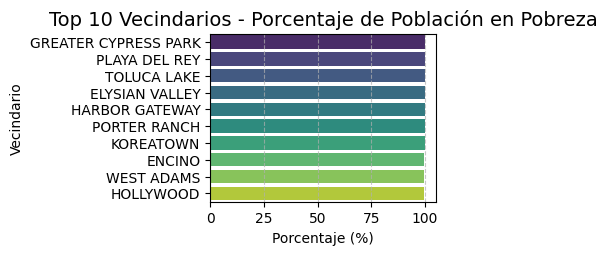

In [104]:
plt.subplot(2, 2, 3)

top10_pobreza = df_poblacionxvecindario[['vecindario', 'Porcentaje Pobreza']].dropna()
top10_pobreza = top10_pobreza.drop_duplicates('vecindario')
top10_pobreza = top10_pobreza.sort_values('Porcentaje Pobreza', ascending=False).head(10)

sns.barplot(data=top10_pobreza, x='Porcentaje Pobreza', y='vecindario', palette='viridis')
plt.title('Top 10 Vecindarios - Porcentaje de Población en Pobreza', fontsize=14)
plt.xlabel('Porcentaje (%)')
plt.ylabel('Vecindario')
plt.grid(axis='x', linestyle='--', alpha=0.7)


### **Cuarto KPI**

Calcular el porcentaje de renta por vecindario

In [105]:
df_poblacionxvecindario['Porcentaje Renta'] = (df_poblacionxvecindario['Renter_occ'] / df_poblacionxvecindario['Total Population']) * 100

df_poblacionxvecindario[['vecindario', 'Total Population', 'Renter_occ', 'Porcentaje Renta']]

vecindario  Total Population  Renter_occ  Porcentaje Renta
0            ARLETA          34932.84     2159.94          6.183122
1       ARROYO SECO          21711.47     3235.61         14.902768
2   ATWATER VILLAGE          11385.40     2902.89         25.496601
3           BEL AIR          26789.14     1943.18          7.253611
4     BOYLE HEIGHTS          81900.56    16001.77         19.538047
..              ...               ...         ...               ...
92       WILMINGTON          59140.55     8086.33         13.673072
93        KOREATOWN          99702.15    36026.35         36.133975
94         WINNETKA          51259.94     7369.18         14.376100
95   WOODLAND HILLS          68837.33    12213.06         17.741914
96      ZAPATA KING          50013.53     8463.65         16.922721

[97 rows x 4 columns]

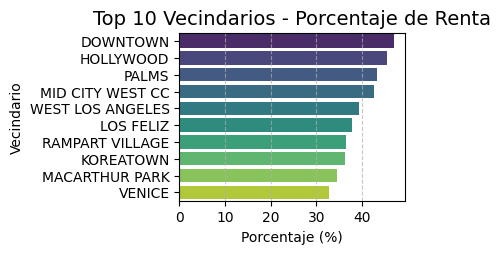

In [106]:
plt.subplot(2, 2, 4)

top10_renta = df_poblacionxvecindario[['vecindario', 'Porcentaje Renta']].dropna()
top10_renta = top10_renta.drop_duplicates('vecindario')
top10_renta = top10_renta.sort_values('Porcentaje Renta', ascending=False).head(10)

sns.barplot(data=top10_renta, x='Porcentaje Renta', y='vecindario', palette='viridis')
plt.title('Top 10 Vecindarios - Porcentaje de Renta', fontsize=14)
plt.xlabel('Porcentaje (%)')
plt.ylabel('Vecindario')
plt.grid(axis='x', linestyle='--', alpha=0.7)


###  **Definición y cálculo de indicadores:**

### Explicación de Indicadores

1. **Índice de Crimen por Población**:
    - **Relevancia**: Este indicador mide la cantidad de crímenes por cada 1,000 habitantes en un vecindario. Es útil para identificar áreas con alta incidencia de delitos en relación con su población, lo que puede ayudar a priorizar recursos de seguridad pública.
    - **Cálculo**: Se divide el número total de crímenes en un vecindario entre la población total del mismo y se multiplica por 1,000. Esto normaliza los datos para que sean comparables entre vecindarios con diferentes tamaños de población.

2. **Porcentaje de Propietarios de Viviendas**:
    - **Relevancia**: Este indicador muestra la proporción de personas que son dueñas de sus viviendas en un vecindario. Es importante porque los vecindarios con un alto porcentaje de propietarios suelen tener mayor estabilidad económica y social.
    - **Cálculo**: Se divide el número de viviendas ocupadas por propietarios entre la población total del vecindario y se multiplica por 100 para obtener un porcentaje.

3. **Porcentaje de Población en Pobreza**:
    - **Relevancia**: Este indicador mide la proporción de personas que viven por debajo del umbral de pobreza en un vecindario. Es relevante para identificar áreas con necesidades económicas y sociales críticas.
    - **Cálculo**: Se divide el número de personas en pobreza entre la población total del vecindario y se multiplica por 100 para obtener un porcentaje.

4. **Porcentaje de Renta**:
    - **Relevancia**: Este indicador mide la proporción de personas que alquilan sus viviendas en un vecindario. Es útil para entender la dinámica de vivienda y la movilidad de la población en el área.
    - **Cálculo**: Se divide el número de viviendas ocupadas por inquilinos entre la población total del vecindario y se multiplica por 100 para obtener un porcentaje.

### Justificación del Cálculo
Cada indicador fue calculado de manera que permita una comparación justa entre vecindarios, independientemente de su tamaño o población. La normalización (por cada 1,000 habitantes o en forma de porcentaje) asegura que los datos sean interpretables y útiles para la toma de decisiones en políticas públicas, planificación urbana y asignación de recursos.

###  **Perfil de un vecindario:**

In [107]:
df_poblacionxvecindario
df_housing_long
gdf_crime_with_area
gdf_business_with_area

LOCATION ACCOUNT #                  BUSINESS NAME  \
0        0003217523-0001-2             MARIA OFELIA NUNEZ   
1        0003211603-0001-0   ONE STOP HOLISTIC HEALTH LLC   
2        0003249387-0001-0                 CHOE SHOW, LLC   
3        0003240128-0001-1  SANTOS ANTONIO RAMOS AJPACAJA   
4        0003236037-0001-9               ASHLEY-ANN FELIX   
...                    ...                            ...   
1607912  0003112677-0001-5           HEADLESS MUSICAL LLC   
1607913  0003310793-0001-9                   KARLA Y NEAL   
1607914  0003469025-0001-8     DOMINIC MOISES PUAC MENCHU   
1607919  0003417591-0001-0          HERITAGE ELECTRIC INC   
1607920  0003341552-0001-0        FESTIVAL HAIR QUEEN LLC   

                          STREET ADDRESS            CITY    ZIP CODE  \
0                     1017 W 88TH STREET     LOS ANGELES  90044-2119   
1               1506 W MANCHESTER AVENUE     LOS ANGELES  90047-5424   
2                   711 S GRAMERCY PLACE     LOS ANGELES  90005-3166   
3                   19948 SATICOY STREET        WINNETKA  91306-2648   
4                       412 W 7TH STREET       SAN PEDRO  90731-3208   
...                                  ...             ...         ...   
1607912          16830 VENTURA BLVD #400          ENCINO  91436-1726   
1607913               4217 DALTON AVENUE     LOS ANGELES  90062-1809   
1607914        4400 S BROADWAY SUITE #02     LOS ANGELES  90037-2791   
1607919  2175 GOODYEAR AVENUE SUITE #109         VENTURA  93003-7761   
1607920               22801 VENTURA BLVD  WOODLAND HILLS  91364-1222   

             LOCATION DESCRIPTION                MAILING ADDRESS MAILING CITY  \
0                 1017 88TH 90044             1017 W 88TH STREET  LOS ANGELES   
1           1506 MANCHESTER 90047       1506 W MANCHESTER AVENUE  LOS ANGELES   
2              711 GRAMERCY 90005           711 S GRAMERCY PLACE  LOS ANGELES   
3        19948 Saticoy 91306-2648                                               
4                   412 7TH 90731           465 N HANFORD AVENUE    SAN PEDRO   
...                           ...                            ...          ...   
1607912  16830 VENTURA 91436-1726  16830 VENTURA BLVD SUITE #400       ENCINO   
1607913    4217 Dalton 90062-1809                                               
1607914  4400 Broadway 90037-2791              141 W 45TH STREET  LOS ANGELES   
1607919  2175 GOODYEAR 93003-7761         223 LUCADA STREET ROOM  SANTA PAULA   
1607920  22801 VENTURA 91364-1222             6427 PINION STREET     OAK PARK   

        MAILING ZIP CODE     NAICS  ...              LOCATION      LAT  \
0             90044-2119  444130.0  ...  (33.9581, -118.2926)  33.9581   
1             90047-5424            ...  (33.9597, -118.3028)  33.9597   
2             90005-3166            ...  (34.0594, -118.3135)  34.0594   
3                         561790.0  ...  (34.2081, -118.5684)  34.2081   
4             90732-2621            ...   (33.738, -118.2861)  33.7380   
...                  ...       ...  ...                   ...      ...   
1607912       91436-1726  711100.0  ...  (34.1586, -118.5008)  34.1586   
1607913                   621610.0  ...  (34.0068, -118.3038)  34.0068   
1607914       90037-2796  812990.0  ...  (34.0035, -118.2779)  34.0035   
1607919            93060  235310.0  ...  (34.2532, -119.2329)  34.2532   
1607920       91377-1210            ...  (34.1662, -118.6236)  34.1662   

              LON                                               text  \
0       -118.2926  1017 W 88TH STREET 1017 W 88TH STREET Hardware...   
1       -118.3028  1506 W MANCHESTER AVENUE 1506 W MANCHESTER AVE...   
2       -118.3135  711 S GRAMERCY PLACE 711 S GRAMERCY PLACE  711...   
3       -118.5684   19948 SATICOY STREET Other services to buildi...   
4       -118.2861  465 N HANFORD AVENUE 412 W 7TH STREET  412 7TH...   
...           ...                                                ...   
1607912 -118.5008  16830 VENTURA BLVD SUITE 

In [108]:
df_poblacionxvecindario

NC_Name  Total Population  White_pop  Black_pop  \
0                         ARLETA          34932.84    2882.67     409.67   
1                    ARROYO SECO          21711.47    4640.35     782.76   
2                ATWATER VILLAGE          11385.40    3450.70     127.80   
3                        BEL AIR          26789.14   22024.61     349.63   
4                  BOYLE HEIGHTS          81900.56    1562.20     640.97   
..                           ...               ...        ...        ...   
92                    WILMINGTON          59140.55    3840.90    1406.41   
93   WILSHIRE CENTER - KOREATOWN          99702.15    7364.20    3608.43   
94                      WINNETKA          51259.94   12768.80    2713.13   
95  WOODLAND HILLS-WARNER CENTER          68837.33   44685.05    3618.24   
96                   ZAPATA KING          50013.53     596.58    5255.97   

    Ameri_es_pop  Asian_pop  Hawn_pi_pop  Hispanic_pop  Other_pop  Multi_pop  \
0          67.64    4061.31        34.96           NaN      37.58     245.05   
1          89.51    3215.37        25.38           NaN      66.98     263.12   
2           0.15    2379.08        71.85           NaN       0.37     252.76   
3           0.02    1787.79         0.01           NaN     156.92     946.28   
4          63.63    2266.59        73.99           NaN      90.30      98.50   
..           ...        ...          ...           ...        ...        ...   
92        173.57    1203.80       361.61           NaN       9.32     306.10   
93        216.59   32842.25       392.87           NaN     628.59    1025.46   
94        105.84    8204.16        23.63           NaN      42.65    1441.14   
95        236.68    7481.77        55.14           NaN      83.33    2819.34   
96         17.10      51.29        94.88           NaN     211.02     149.12   

    In_Poverty  Owner_occ  Renter_occ       vecindario  \
0     34700.56    5590.27     2159.94           ARLETA   
1     21582.85    4138.14     3235.61      ARROYO SECO   
2     11345.53    1877.30     2902.89  ATWATER VILLAGE   
3     26623.97    8939.21     1943.18          BEL AIR   
4     81144.31    4743.28    16001.77    BOYLE HEIGHTS   
..         ...        ...         ...              ...   
92    58039.47    6169.10     8086.33       WILMINGTON   
93    99508.61    2141.05    36026.35        KOREATOWN   
94    51043.62    7773.78     7369.18         WINNETKA   
95    68502.94   15715.69    12213.06   WOODLAND HILLS   
96    49808.63    2940.07     8463.65      ZAPATA KING   

    Porcentaje Propietarios  Porcentaje Pobreza  Porcentaje Renta  
0                 16.002907           99.335067          6.183122  
1                 19.059695           99.407594         14.902768  
2                 16.488661           99.649815         25.496601  
3                 33.368783           99.383444          7.253611  
4                  5.791511           99.076624         19.538047  
..                      ...                 ...               ...  
92                10.431252           98.138198         13.673072  
93                 2.147446           99.805882         36.133975  
94                15.165410           99.577994         14.376100  
95                22.830185           99.514232         17.741914  
96                 5.878549           99.590311         16.922721  

[97 rows x 17 columns]

In [109]:
vecindarios_seleccionados = ['VAN NUYS', 'BOYLE HEIGHTS', 'BEL AIR']

perfil_vecindarios = df_poblacionxvecindario[df_poblacionxvecindario['vecindario'].isin(vecindarios_seleccionados)].copy()

crimenes_por_vecindario = gdf_crime_with_area['vecindario'].value_counts()
perfil_vecindarios['Total Crimenes'] = perfil_vecindarios['vecindario'].map(crimenes_por_vecindario)

precios_por_vecindario = df_housing_long.groupby('vecindario')['Fecha'].mean()
perfil_vecindarios['Precio Promedio Vivienda'] = perfil_vecindarios['vecindario'].map(precios_por_vecindario)

perfil_vecindarios['Indice Crimen por Poblacion'] = (perfil_vecindarios['Total Crimenes'] / perfil_vecindarios['Total Population']) * 1000
perfil_vecindarios['Porcentaje Propietarios'] = (perfil_vecindarios['Owner_occ'] / perfil_vecindarios['Total Population']) * 100
perfil_vecindarios['Porcentaje Renta'] = (perfil_vecindarios['Renter_occ'] / perfil_vecindarios['Total Population']) * 100

perfil_vecindarios[['NC_Name', 'Total Population', 'Total Crimenes', 'Indice Crimen por Poblacion', 
                    'Precio Promedio Vivienda', 'Porcentaje Propietarios', 'Porcentaje Renta']]

NC_Name  Total Population  Total Crimenes  \
3         BEL AIR          26789.14            1164   
4   BOYLE HEIGHTS          81900.56           19688   
81       VAN NUYS          86434.13           23379   

    Indice Crimen por Poblacion      Precio Promedio Vivienda  \
3                     43.450443 2012-08-30 04:35:38.613861376   
4                    240.389077 2012-08-30 04:35:38.613861376   
81                   270.483431 2012-08-30 04:35:38.613861376   

    Porcentaje Propietarios  Porcentaje Renta  
3                 33.368783          7.253611  
4                  5.791511         19.538047  
81                 8.581691         23.583566

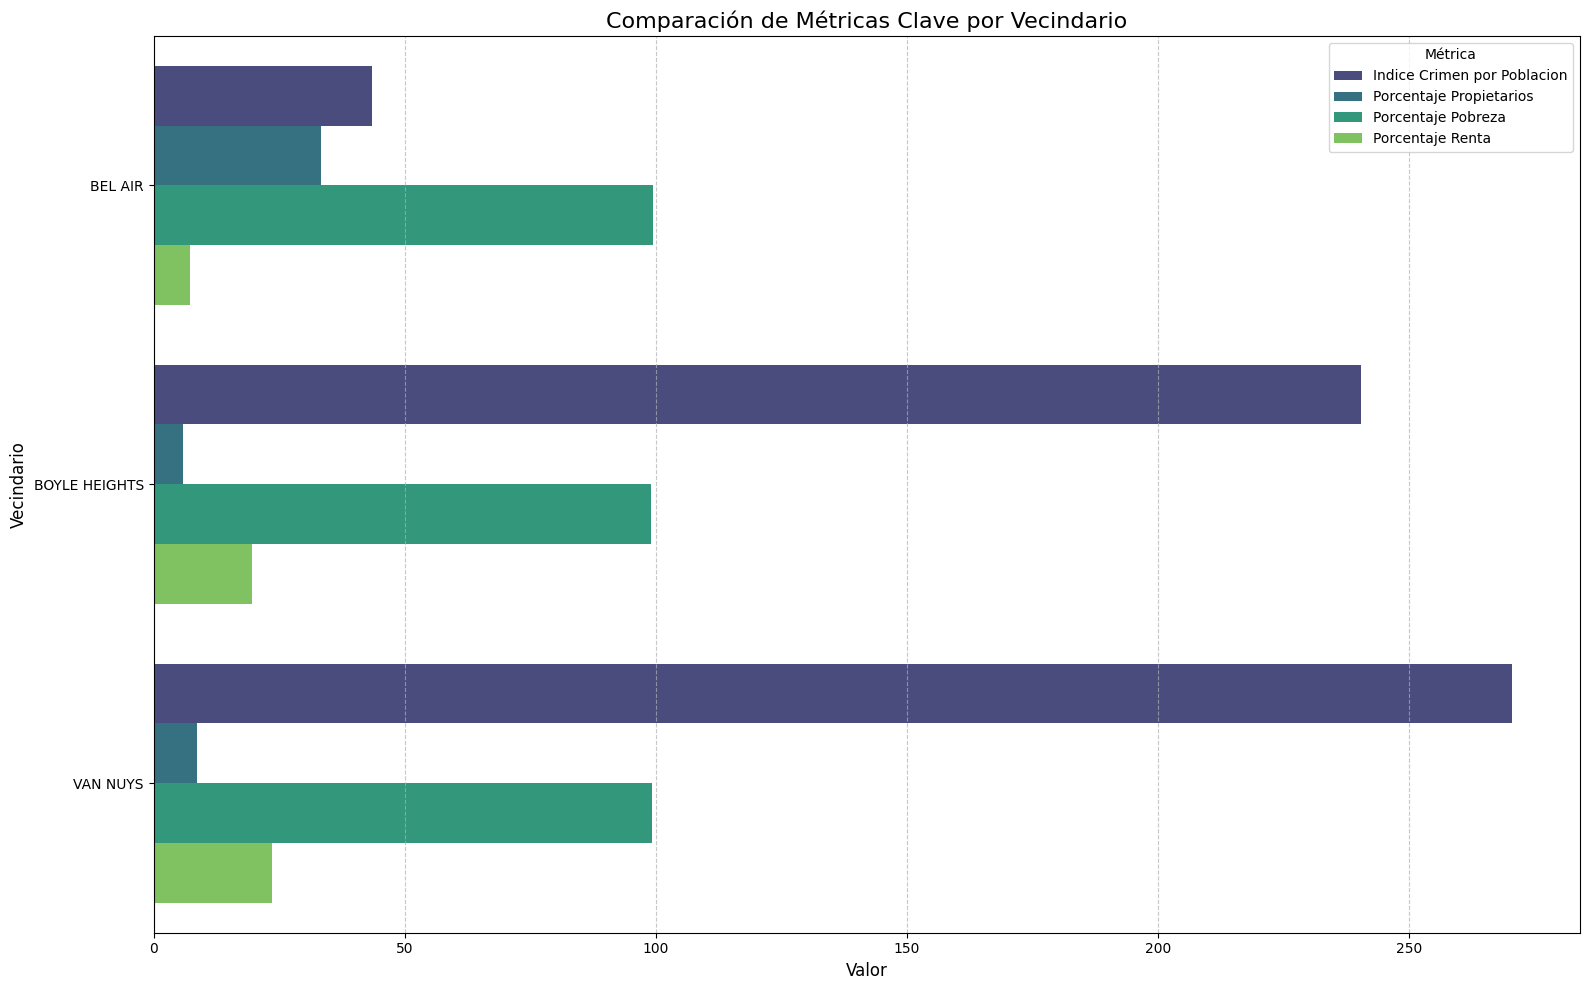

In [ ]:
plt.figure(figsize=(16, 10))

metricas = ['Indice Crimen por Poblacion', 'Porcentaje Propietarios', 'Porcentaje Pobreza', 'Porcentaje Renta']
perfil_vecindarios_melted = perfil_vecindarios.melt(id_vars=['vecindario'], value_vars=metricas, 
                                                    var_name='Métrica', value_name='Valor')

sns.barplot(data=perfil_vecindarios_melted, x='Valor', y='vecindario', hue='Métrica', palette='viridis')

plt.title('Comparación de Métricas Clave por Vecindario', fontsize=16)
plt.xlabel('Valor', fontsize=12)
plt.ylabel('Vecindario', fontsize=12)
plt.legend(title='Métrica', fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

### **BEL AIR. Interpretación:**
Bel Air muestra un contraste interesante: a pesar de tener un bajo nivel de criminalidad y una alta tasa de propietarios, su porcentaje de pobreza es sorprendentemente alto. El bajo porcentaje de renta reafirma que es una zona con predominancia de viviendas propias, aunque con desigualdades internas.

### **BOYLE HEIGHTS. Interpretación:**
Boyle Heights representa un vecindario altamente vulnerable, con alta criminalidad, pocos propietarios y altos niveles de pobreza. Aunque la renta no es excesivamente alta, la situación general indica una zona con múltiples carencias, posiblemente con población flotante y viviendas de baja estabilidad.

### **VAN NUYS. Interpretación:**
Similar a Boyle Heights, Van Nuys es una zona con alta criminalidad y vulnerabilidad social, aunque presenta una renta algo mayor. Esto puede indicar presión habitacional o una mayor proporción de arrendamientos temporales. Es un vecindario donde probablemente el alquiler predomina por sobre la propiedad.

In [111]:
vecindarios_seleccionados = ['VAN NUYS', 'BOYLE HEIGHTS', 'BEL AIR']

estadistico_vecindarios = perfil_vecindarios[perfil_vecindarios['vecindario'].isin(vecindarios_seleccionados)]

required_columns = ['NC_Name', 'Total Population', 'Total Crimenes', 
                    'Indice Crimen por Poblacion', 'Porcentaje Propietarios', 
                    'Porcentaje Renta']

missing_columns = [col for col in required_columns if col not in estadistico_vecindarios.columns]
if missing_columns:
    print(f"Las siguientes columnas faltan en el DataFrame: {missing_columns}")
else:
    print(estadistico_vecindarios[required_columns])

          NC_Name  Total Population  Total Crimenes  \
3         BEL AIR          26789.14            1164   
4   BOYLE HEIGHTS          81900.56           19688   
81       VAN NUYS          86434.13           23379   

    Indice Crimen por Poblacion  Porcentaje Propietarios  Porcentaje Renta  
3                     43.450443                33.368783          7.253611  
4                    240.389077                 5.791511         19.538047  
81                   270.483431                 8.581691         23.583566  


# **Fase 3**

### **Correlaciones**

In [112]:
df_poblacionxvecindario['vecindario'] = df_poblacionxvecindario['vecindario'].str.upper()

kpis_soc = df_poblacionxvecindario[['vecindario', 'Porcentaje Propietarios', 'Porcentaje Pobreza', 'Porcentaje Renta']].set_index('vecindario')

kpis_crimen = datos_merged[['vecindario', 'Indice Crimen por Poblacion']].set_index('vecindario')

df_kpis = kpis_crimen.join(kpis_soc, how='inner')

df_kpis.head()

Indice Crimen por Poblacion  Porcentaje Propietarios  \
vecindario                                                              
ARLETA                            109.696206                16.002907   
ATWATER VILLAGE                   273.069018                16.488661   
BEL AIR                            43.450443                33.368783   
BOYLE HEIGHTS                     240.389077                 5.791511   
CANOGA PARK                       331.335101                11.057939   

                 Porcentaje Pobreza  Porcentaje Renta  
vecindario                                             
ARLETA                    99.335067          6.183122  
ATWATER VILLAGE           99.649815         25.496601  
BEL AIR                   99.383444          7.253611  
BOYLE HEIGHTS             99.076624         19.538047  
CANOGA PARK               98.986545         18.840880

                             Indice Crimen por Poblacion  \
Indice Crimen por Poblacion                     1.000000   
Porcentaje Propietarios                        -0.396130   
Porcentaje Pobreza                              0.092904   
Porcentaje Renta                                0.535868   

                             Porcentaje Propietarios  Porcentaje Pobreza  \
Indice Crimen por Poblacion                -0.396130            0.092904   
Porcentaje Propietarios                     1.000000           -0.021272   
Porcentaje Pobreza                         -0.021272            1.000000   
Porcentaje Renta                           -0.596274            0.088052   

                             Porcentaje Renta  
Indice Crimen por Poblacion          0.535868  
Porcentaje Propietarios             -0.596274  
Porcentaje Pobreza                   0.088052  
Porcentaje Renta                     1.000000  


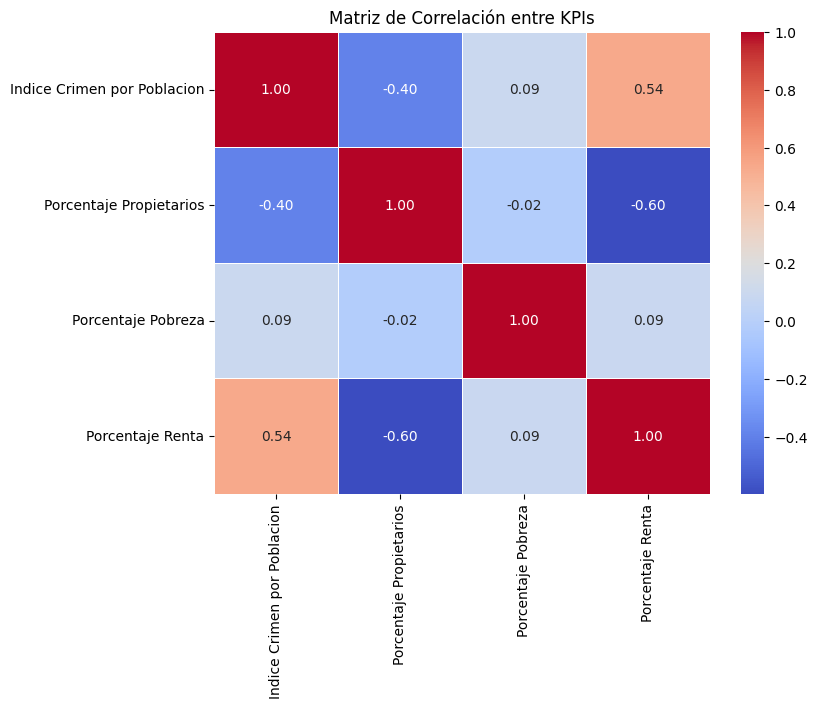

In [113]:
correlaciones = df_kpis.corr(method='pearson')
print(correlaciones)

plt.figure(figsize=(8, 6))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación entre KPIs')
plt.show()

Resumen del Análisis de Correlación entre KPIs

Se analizó la correlación entre cuatro indicadores clave: índice de crimen por población, porcentaje de propietarios, porcentaje de renta y porcentaje de pobreza.

Mayor propiedad, menor crimen: Existe una correlación negativa moderada (-0.40), sugiriendo que la propiedad de vivienda está asociada con menor criminalidad.

Más renta, más crimen: Hay una correlación positiva moderada (0.54) entre la renta y el crimen, posiblemente por menor estabilidad residencial.

Crimen y pobreza: La relación es casi nula (0.09), lo que indica que no hay una conexión lineal clara entre ambos.

Propiedad vs. renta: Relación negativa fuerte (-0.60), como era esperado.

Pobreza: No muestra correlaciones fuertes con otros indicadores, lo que sugiere efectos más complejos o indirectos.

Estos hallazgos ofrecen pistas valiosas para orientar estrategias de seguridad y vivienda en la ciudad.

### **Regresion**

In [114]:
df_housing_long.head()

RegionID             RegionName    RegionType         City  \
0    118208      South Los Angeles  neighborhood  Los Angeles   
1    268496  Southeast Los Angeles  neighborhood  Los Angeles   
2     32059              Hollywood  neighborhood  Los Angeles   
3     46795        North Hollywood  neighborhood  Los Angeles   
4     41466               Van Nuys  neighborhood  Los Angeles   

                                Metro          CountyName      Fecha  \
0  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2000-01-31   
1  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2000-01-31   
2  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2000-01-31   
3  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2000-01-31   
4  Los Angeles-Long Beach-Anaheim, CA  Los Angeles County 2000-01-31   

          Precio             vecindario  
0  131467.995341      SOUTH LOS ANGELES  
1  115164.134048  SOUTHEAST LOS ANGELES  
2  230073.463042              HOLLYWOOD  
3  164554.215903        NORTH HOLLYWOOD  
4  137092.087282               VAN NUYS

In [115]:
df_precios = df_housing_long.groupby('vecindario')['Precio'].mean().reset_index()
df_precios.rename(columns={'Precio': 'Precio Promedio'}, inplace=True)

In [116]:
df_precios['vecindario'] = df_precios['vecindario'].str.upper()
df_kpis = df_kpis.reset_index() 

df_modelo = df_kpis.merge(df_precios, on='vecindario', how='inner')


In [117]:
df_modelo.head()

vecindario  Indice Crimen por Poblacion  Porcentaje Propietarios  \
0           ARLETA                   109.696206                16.002907   
1  ATWATER VILLAGE                   273.069018                16.488661   
2          BEL AIR                    43.450443                33.368783   
3    BOYLE HEIGHTS                   240.389077                 5.791511   
4      CANOGA PARK                   331.335101                11.057939   

   Porcentaje Pobreza  Porcentaje Renta  Precio Promedio  
0           99.335067          6.183122     4.098018e+05  
1           99.649815         25.496601     7.062729e+05  
2           99.383444          7.253611     2.287136e+06  
3           99.076624         19.538047     3.328267e+05  
4           98.986545         18.840880     3.977344e+05

In [118]:
X = df_modelo[['Porcentaje Propietarios', 'Porcentaje Renta', 'Indice Crimen por Poblacion', 'Porcentaje Pobreza']]
y = np.log(df_modelo['Precio Promedio'])


In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)


print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
pd.DataFrame({'Variable': X.columns, 'Coeficiente': modelo.coef_})

R²: 0.19707522601202843
MSE: 0.04001641841526587


Variable  Coeficiente
0      Porcentaje Propietarios     0.021457
1             Porcentaje Renta     0.014254
2  Indice Crimen por Poblacion     0.000052
3           Porcentaje Pobreza     0.004362

### **Analsisi de clusters**

In [120]:
df_cluster = df_kpis.set_index('vecindario')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)


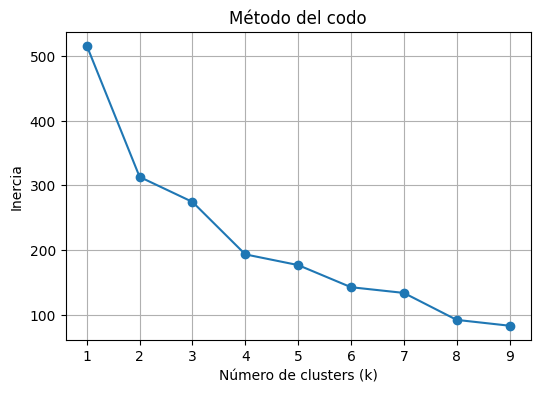

In [121]:
inertia = []
K_range = range(1, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del codo')
plt.grid(True)
plt.show()


In [122]:
kmeans = KMeans(n_clusters=4, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(X_scaled)


In [123]:
df_cluster.groupby('Cluster').mean()

Indice Crimen por Poblacion  Porcentaje Propietarios  \
Cluster                                                         
0                         703.309817                 6.950548   
1                         336.937338                17.222622   
2                        1497.099897                 8.043367   
3                         127.624983                11.515594   

         Porcentaje Pobreza  Porcentaje Renta  
Cluster                                        
0                 99.037315         35.357717  
1                 98.691022         16.410586  
2                 99.180577         34.762278  
3                 75.842679         23.690072

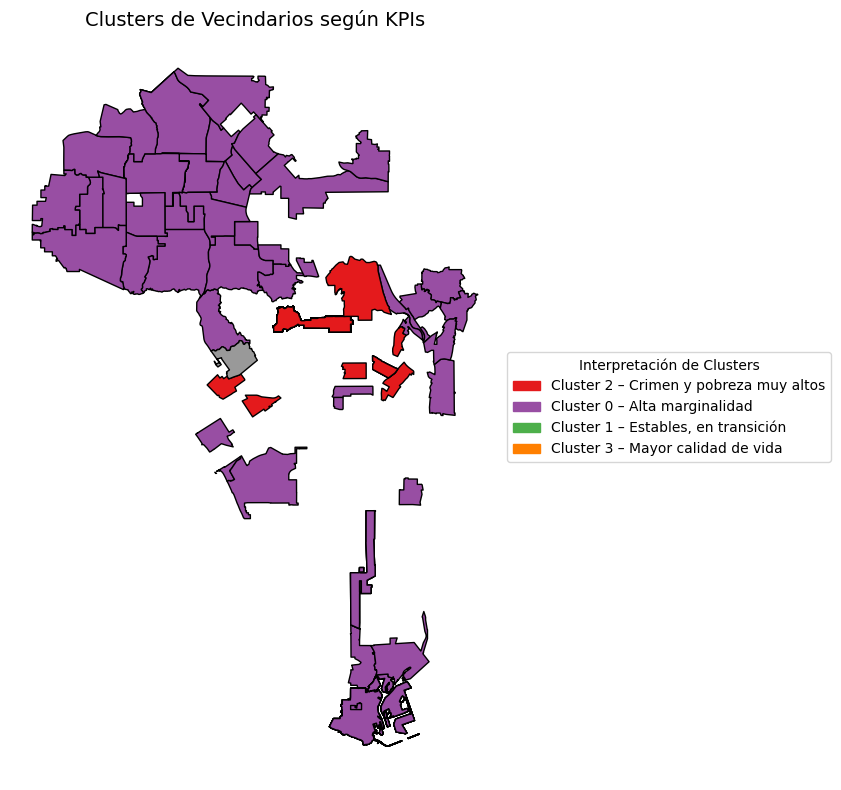

In [124]:
gdf_clusters = gdf_areaxvecindario.copy()
gdf_clusters['vecindario'] = gdf_clusters['name'].str.upper()

gdf_clusters = gdf_clusters.merge(df_cluster[['Cluster']], left_on='vecindario', right_index=True, how='left')

fig, ax = plt.subplots(figsize=(10, 8))
gdf_clusters.plot(column='Cluster', cmap='Set1', legend=False, edgecolor='black', ax=ax)

plt.title('Clusters de Vecindarios según KPIs', fontsize=14)
plt.axis('off')

legend_patches = [
    mpatches.Patch(color='#e41a1c', label='Cluster 2 – Crimen y pobreza muy altos'),
    mpatches.Patch(color='#984ea3', label='Cluster 0 – Alta marginalidad'),
    mpatches.Patch(color='#4daf4a', label='Cluster 1 – Estables, en transición'),
    mpatches.Patch(color='#ff7f00', label='Cluster 3 – Mayor calidad de vida')
]


plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), title="Interpretación de Clusters")

plt.tight_layout()
plt.show()

In [125]:
df_cluster.groupby('Cluster').mean()

Indice Crimen por Poblacion  Porcentaje Propietarios  \
Cluster                                                         
0                         703.309817                 6.950548   
1                         336.937338                17.222622   
2                        1497.099897                 8.043367   
3                         127.624983                11.515594   

         Porcentaje Pobreza  Porcentaje Renta  
Cluster                                        
0                 99.037315         35.357717  
1                 98.691022         16.410586  
2                 99.180577         34.762278  
3                 75.842679         23.690072

In [126]:
df_cluster['Cluster'].value_counts()

Cluster
1    68
0    39
2    21
3     1
Name: count, dtype: int64

### **SEM**

In [127]:
df_cluster

Indice Crimen por Poblacion  Porcentaje Propietarios  \
vecindario                                                              
ARLETA                            109.696206                16.002907   
ATWATER VILLAGE                   273.069018                16.488661   
BEL AIR                            43.450443                33.368783   
BOYLE HEIGHTS                     240.389077                 5.791511   
CANOGA PARK                       331.335101                11.057939   
...                                      ...                      ...   
WESTWOOD                          127.624983                11.515594   
WILMINGTON                        211.310176                10.431252   
KOREATOWN                         136.556734                 2.147446   
WINNETKA                          182.384139                15.165410   
WOODLAND HILLS                    196.259791                22.830185   

                 Porcentaje Pobreza  Porcentaje Renta  Cluster  
vecindario                                                      
ARLETA                    99.335067          6.183122        1  
ATWATER VILLAGE           99.649815         25.496601        1  
BEL AIR                   99.383444          7.253611        1  
BOYLE HEIGHTS             99.076624         19.538047        1  
CANOGA PARK               98.986545         18.840880        1  
...                             ...               ...      ...  
WESTWOOD                  75.842679         23.690072        3  
WILMINGTON                98.138198         13.673072        1  
KOREATOWN                 99.805882         36.133975        0  
WINNETKA                  99.577994         14.376100        1  
WOODLAND HILLS            99.514232         17.741914        1  

[129 rows x 5 columns]

In [128]:
columnas_kpi = [
    'Indice Crimen por Poblacion',
    'Porcentaje Propietarios',
    'Porcentaje Pobreza',
    'Porcentaje Renta'
]

scaler = StandardScaler()
df_cluster[columnas_kpi] = scaler.fit_transform(df_cluster[columnas_kpi])

df_cluster['Felicidad'] = (
    + df_cluster['Porcentaje Propietarios']
    - df_cluster['Porcentaje Renta']
    - df_cluster['Porcentaje Pobreza']
    - df_cluster['Indice Crimen por Poblacion']
)


In [ ]:
modelo_sem = """
Felicidad ~ Indice_Crimen_por_Poblacion + Porcentaje_Propietarios + Porcentaje_Pobreza + Porcentaje_Renta
Felicidad ~~ Felicidad
"""

model = Model(modelo_sem)

data_sem = df_cluster.copy()

data_sem = data_sem.dropna()

scaler = StandardScaler()
numeric_columns = ["Indice Crimen por Poblacion", "Porcentaje Propietarios", "Porcentaje Pobreza", "Porcentaje Renta"]
data_sem[numeric_columns] = scaler.fit_transform(data_sem[numeric_columns])

data_sem['Felicidad'] = 0 

correlation_matrix = data_sem[numeric_columns].corr()
print("Correlation Matrix:\n", correlation_matrix)

if data_sem.isnull().values.any():
    raise ValueError("Data contains missing values. Please handle them before fitting the model.")

try:
    model.fit(data_sem, optimizer=Optimizer('SLSQP')) 
    results = model.inspect()
    print(results)
except Exception as e:
    print("Error fitting the SEM model:", e)
    print("Consider further preprocessing or simplifying the model.")

Correlation Matrix:
                              Indice Crimen por Poblacion  \
Indice Crimen por Poblacion                     1.000000   
Porcentaje Propietarios                        -0.396130   
Porcentaje Pobreza                              0.092904   
Porcentaje Renta                                0.535868   

                             Porcentaje Propietarios  Porcentaje Pobreza  \
Indice Crimen por Poblacion                -0.396130            0.092904   
Porcentaje Propietarios                     1.000000           -0.021272   
Porcentaje Pobreza                         -0.021272            1.000000   
Porcentaje Renta                           -0.596274            0.088052   

                             Porcentaje Renta  
Indice Crimen por Poblacion          0.535868  
Porcentaje Propietarios             -0.596274  
Porcentaje Pobreza                   0.088052  
Porcentaje Renta                     1.000000  
Error fitting the SEM model: load_dataset method must be 

Los datos sí reflejan patrones sociales coherentes, especialmente en la relación entre crimen, renta y propiedad. La única variable que no aporta mucho por ahora es pobreza, pero eso probablemente se debe a que tus datos están sesgados hacia zonas pobres.


### **Series de Tiempo**

Solo lo haremos con dos kpis ya que Porcentaje Propietarios y Porcentaje Pobreza no tienen fechas y no se puede ver su tendencia.
Usaremos para un modelo prophet y otro arima

In [130]:
df_kpis

vecindario  Indice Crimen por Poblacion  Porcentaje Propietarios  \
0             ARLETA                   109.696206                16.002907   
1    ATWATER VILLAGE                   273.069018                16.488661   
2            BEL AIR                    43.450443                33.368783   
3      BOYLE HEIGHTS                   240.389077                 5.791511   
4        CANOGA PARK                   331.335101                11.057939   
..               ...                          ...                      ...   
124         WESTWOOD                   127.624983                11.515594   
125       WILMINGTON                   211.310176                10.431252   
126        KOREATOWN                   136.556734                 2.147446   
127         WINNETKA                   182.384139                15.165410   
128   WOODLAND HILLS                   196.259791                22.830185   

     Porcentaje Pobreza  Porcentaje Renta  
0             99.335067          6.183122  
1             99.649815         25.496601  
2             99.383444          7.253611  
3             99.076624         19.538047  
4             98.986545         18.840880  
..                  ...               ...  
124           75.842679         23.690072  
125           98.138198         13.673072  
126           99.805882         36.133975  
127           99.577994         14.376100  
128           99.514232         17.741914  

[129 rows x 5 columns]

Seleccionamos unicamente 3 vecindarios para poder llevar este estudio

### **Tendencia de KPI  de Crimen por vivienda**

In [131]:
gdf_crime_data

DR_NO  Date Rptd   DATE OCC  TIME OCC  AREA   AREA NAME  \
0        190326475 2020-03-01 2020-03-01  21:30:00     7    Wilshire   
1        200106753 2020-02-09 2020-02-08  18:00:00     1     Central   
2        200320258 2020-11-11 2020-11-04  17:00:00     3   Southwest   
3        200907217 2023-05-10 2020-03-10  20:37:00     9    Van Nuys   
4        200412582 2020-09-09 2020-09-09  06:30:00     4  Hollenbeck   
...            ...        ...        ...       ...   ...         ...   
1005194  250304203 2025-02-20 2025-02-13  21:00:00     3   Southwest   
1005195  250504051 2025-01-14 2025-01-14  12:50:00     5      Harbor   
1005196  250304284 2025-03-31 2025-03-30  21:00:00     3   Southwest   
1005197  251604136 2025-02-27 2025-02-27  15:50:00    16    Foothill   
1005198  251904210 2025-03-25 2025-03-25  12:35:00    19     Mission   

         Rpt Dist No  Part 1-2  Crm Cd  \
0                784         1     510   
1                182         1     330   
2                356         1     480   
3                964         1     343   
4                413         1     510   
...              ...       ...     ...   
1005194          325         1     522   
1005195          509         1     210   
1005196          328         1     510   
1005197         1664         1     510   
1005198         1944         2     850   

                                               Crm Cd Desc  ... Vict Descent  \
0                                         VEHICLE - STOLEN  ...            O   
1                                    BURGLARY FROM VEHICLE  ...            O   
2                                            BIKE - STOLEN  ...            X   
3                 SHOPLIFTING-GRAND THEFT ($950.01 & OVER)  ...            O   
4                                         VEHICLE - STOLEN  ...                
...                                                    ...  ...          ...   
1005194  VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, B...  ...                
1005195                                            ROBBERY  ...            H   
1005196                                   VEHICLE - STOLEN  ...                
1005197                                   VEHICLE - STOLEN  ...                
1005198                                  INDECENT EXPOSURE  ...            H   

         Premis Cd                                   Premis Desc Status  \
0            101.0                                        STREET     AA   
1            128.0             BUS STOP/LAYOVER (ALSO QUERY 124)     IC   
2            502.0  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)     IC   
3            405.0                                CLOTHING STORE     IC   
4            101.0                                        STREET     IC   
...            ...                                           ...    ...   
1005194      108.0                                   PARKING LOT     IC   
1005195      721.0                                   HIGH SCHOOL     IC   
1005196      101.0                                        STREET     IC   
1005197      101.0                                        STREET     AA   
1005198      721.0                                   HIGH SCHOOL     IC   

          Status Desc Crm Cd 1                                  LOCATION  \
0        Adult Arrest    510.0   1900 S  LONGWOOD                     AV   
1         Invest Cont    330.0   1000 S  FLOWER                       ST   
2         Invest Cont    480.0   1400 W  37TH                         ST   
3         Invest Cont    343.0  14000    RIVERSIDE                    DR   
4         Invest Cont    510.0                          200 E  AVENUE 28   
...               ...      ...                                       ...   
1005194   Invest Cont    522.0   2600    ELLENDALE                    PL   
1005195   Invest Cont    210.0  24300    WESTERN                      AV   
1005196   Invest Cont    510.0    700 W  32ND                         ST   
1005197  Adult Arrest

In [132]:
gdf_crime_data['mes'] = gdf_crime_data['DATE OCC'].dt.to_period('M')
crimen_mensual = gdf_crime_data.groupby(['mes', 'AREA NAME']).size().reset_index(name='Total Crimenes')

crimen_mensual['Fecha'] = crimen_mensual['mes'].dt.to_timestamp()

In [133]:
vecindarios_seleccionados = ['Rampart', 'Hollywood', 'Van Nuys']
df_crimen_select = crimen_mensual[crimen_mensual['AREA NAME'].isin(vecindarios_seleccionados)]


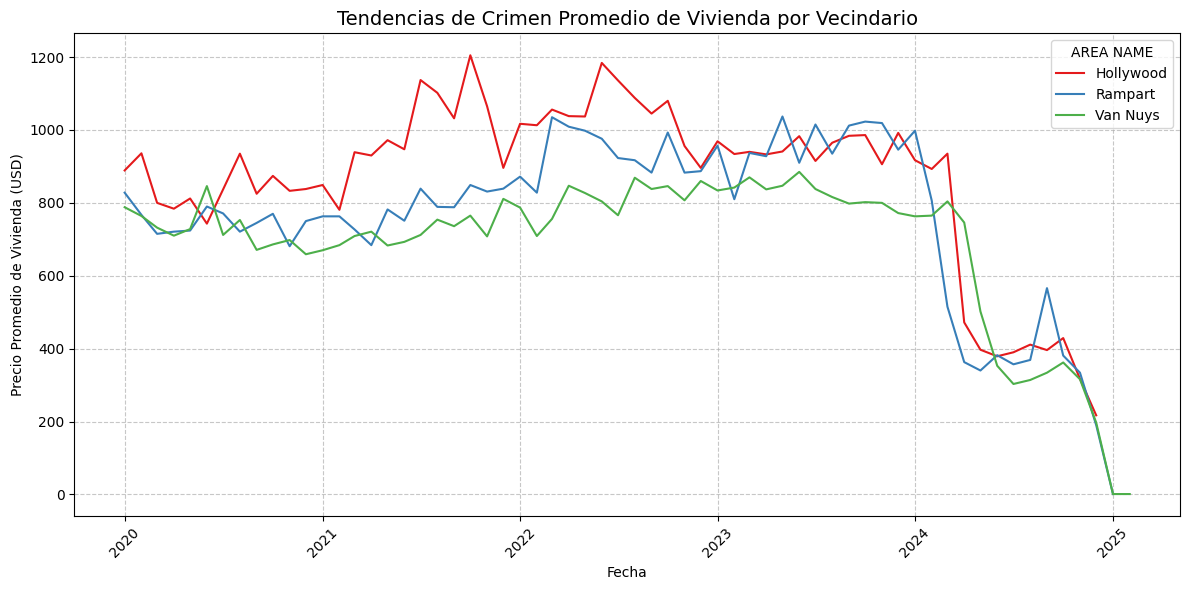

In [134]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_crimen_select, x='Fecha', y='Total Crimenes', hue='AREA NAME', palette='Set1')
plt.title('Tendencias de Crimen Promedio de Vivienda por Vecindario', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Precio Promedio de Vivienda (USD)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [135]:
duplicados = df_crimen_select[df_crimen_select.duplicated(subset='Fecha', keep=False)]
print(duplicados)

          mes  AREA NAME  Total Crimenes      Fecha
6     2020-01  Hollywood             889 2020-01-01
13    2020-01    Rampart             828 2020-01-01
17    2020-01   Van Nuys             788 2020-01-01
27    2020-02  Hollywood             936 2020-02-01
34    2020-02    Rampart             767 2020-02-01
...       ...        ...             ...        ...
1245  2024-12  Hollywood             217 2024-12-01
1252  2024-12    Rampart             190 2024-12-01
1256  2024-12   Van Nuys             197 2024-12-01
1271  2025-01    Rampart               1 2025-01-01
1275  2025-01   Van Nuys               1 2025-01-01

[182 rows x 4 columns]


In [136]:
df_crimen_select['Fecha'] = pd.to_datetime(df_crimen_select['Fecha'])

serie = df_crimen_select.groupby(pd.Grouper(key='Fecha', freq='MS'))['Total Crimenes'].sum()

serie = serie.dropna()  

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:Adding TBB (c:\Users\n9n15\progra\.venv\Lib\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\n9n15\AppData\Local\Temp\tmpflpapyu8\4id5sjf3.json
DEBUG:cmdstanpy:input tempfile: C:\Users\n9n15\AppData\Local\Temp\tmpflpapyu8\mgajfate.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\n9n15\\progra\\.venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=43668', 'data', 'file=C:\\Users\\n9n15\\AppData\\Local\\Temp\\tmpflpapyu8\\4id5sjf3.json', 'init=C:\\Users\\n9n15\\AppData\\Local\\Temp\\tmpflpapyu8\\mgajfate.json', 'output', 'file=C:\\Users\\n9n15\\AppDat

          ds    y
0 2020-01-01  828
1 2020-02-01  767
2 2020-03-01  715
3 2020-04-01  721
4 2020-05-01  724
0
55


23:29:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


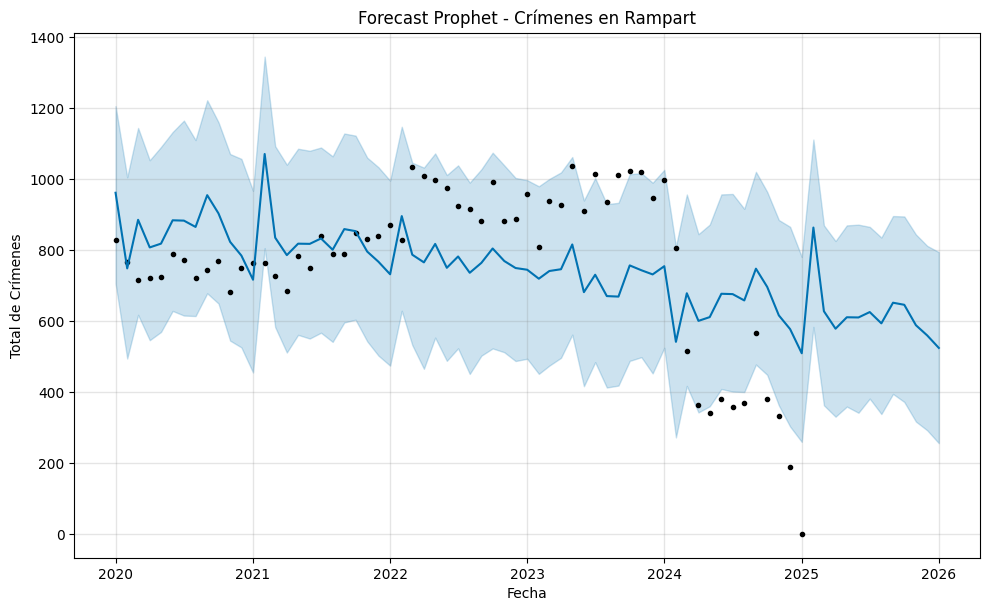

In [137]:
vecindario_forecast = 'Rampart'
df_forecast = df_crimen_select[df_crimen_select['AREA NAME'] == vecindario_forecast].copy()
df_forecast['mes'] = df_forecast['mes'].dt.to_timestamp()

df_grouped = df_forecast.groupby('mes')['Total Crimenes'].sum().reset_index()
df_grouped.columns = ['ds', 'y']

print(df_grouped.head())
print(df_grouped['y'].isna().sum())
print(df_grouped['y'].nunique())


modelo = Prophet()
modelo.fit(df_grouped)

periodos = 12 
future = modelo.make_future_dataframe(periods=periodos, freq='MS')

forecast = modelo.predict(future)

modelo.plot(forecast)
plt.title(f'Forecast Prophet - Crímenes en {vecindario_forecast}')
plt.xlabel('Fecha')
plt.ylabel('Total de Crímenes')
plt.grid(True)
plt.show()

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\n9n15\AppData\Local\Temp\tmpflpapyu8\lq3q4f3t.json
DEBUG:cmdstanpy:input tempfile: C:\Users\n9n15\AppData\Local\Temp\tmpflpapyu8\1r52glfs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\n9n15\\progra\\.venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=71477', 'data', 'file=C:\\Users\\n9n15\\AppData\\Local\\Temp\\tmpflpapyu8\\lq3q4f3t.json', 'init=C:\\Users\\n9n15\\AppData\\Local\\Temp\\tmpflpapyu8\\1r52glfs.json', 'output', 'file=C:\\Users\\n9n15\\AppData\\Local\\Temp\\tmpflpapyu8\\prophet_modelvdqdvg0z\\prophet_model-20250507232939.csv', 'method=op

          ds    y
0 2020-01-01  889
1 2020-02-01  936
2 2020-03-01  800
3 2020-04-01  784
4 2020-05-01  812
0
58


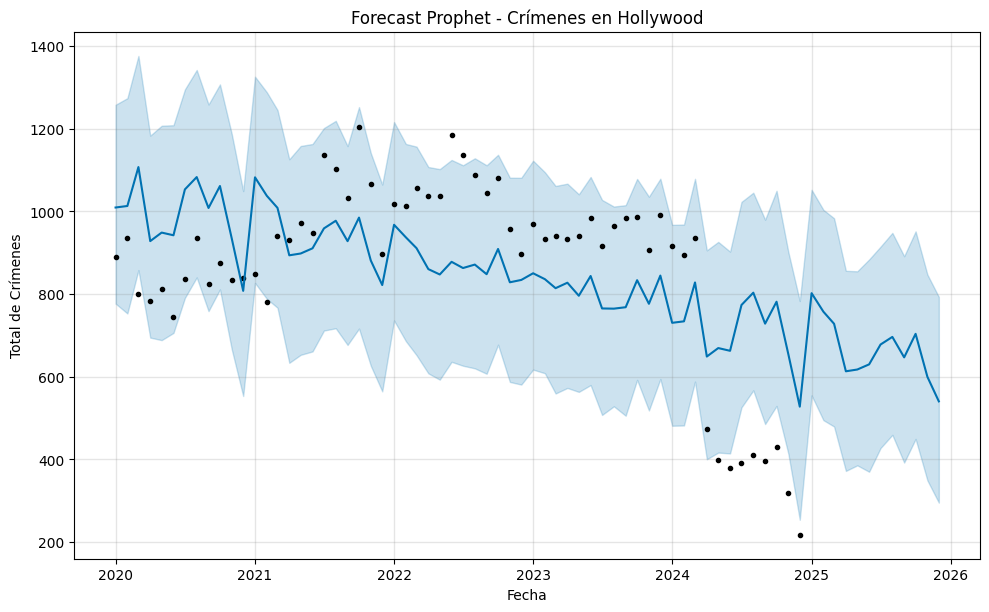

In [138]:
vecindario_forecast = 'Hollywood'
df_forecast = df_crimen_select[df_crimen_select['AREA NAME'] == vecindario_forecast].copy()
df_forecast['mes'] = df_forecast['mes'].dt.to_timestamp()

df_grouped = df_forecast.groupby('mes')['Total Crimenes'].sum().reset_index()
df_grouped.columns = ['ds', 'y']  

print(df_grouped.head())
print(df_grouped['y'].isna().sum())
print(df_grouped['y'].nunique())

modelo = Prophet()
modelo.fit(df_grouped)

periodos = 12 
future = modelo.make_future_dataframe(periods=periodos, freq='MS')

forecast = modelo.predict(future)

modelo.plot(forecast)
plt.title(f'Forecast Prophet - Crímenes en {vecindario_forecast}')
plt.xlabel('Fecha')
plt.ylabel('Total de Crímenes')
plt.grid(True)
plt.show()

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\n9n15\AppData\Local\Temp\tmpflpapyu8\rxj99pbx.json
DEBUG:cmdstanpy:input tempfile: C:\Users\n9n15\AppData\Local\Temp\tmpflpapyu8\p3whih21.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\n9n15\\progra\\.venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=3582', 'data', 'file=C:\\Users\\n9n15\\AppData\\Local\\Temp\\tmpflpapyu8\\rxj99pbx.json', 'init=C:\\Users\\n9n15\\AppData\\Local\\Temp\\tmpflpapyu8\\p3whih21.json', 'output', 'file=C:\\Users\\n9n15\\AppData\\Local\\Temp\\tmpflpapyu8\\prophet_model17cfgb4u\\prophet_model-20250507232939.csv', 'method=opt

          ds    y
0 2020-01-01  788
1 2020-02-01  764
2 2020-03-01  732
3 2020-04-01  710
4 2020-05-01  728
0
54


23:29:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


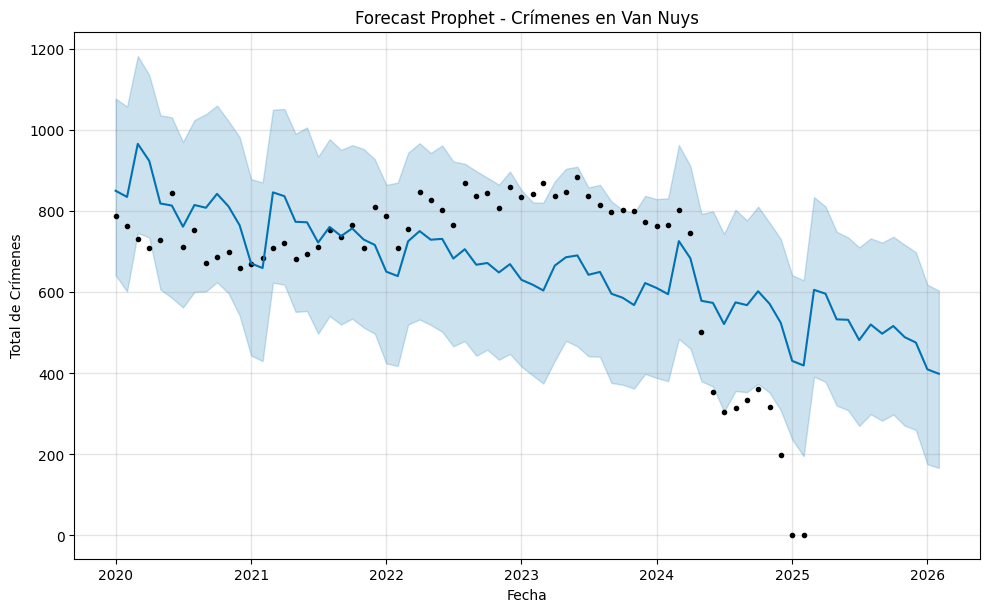

In [139]:
vecindario_forecast = 'Van Nuys'
df_forecast = df_crimen_select[df_crimen_select['AREA NAME'] == vecindario_forecast].copy()
df_forecast['mes'] = df_forecast['mes'].dt.to_timestamp()

df_grouped = df_forecast.groupby('mes')['Total Crimenes'].sum().reset_index()
df_grouped.columns = ['ds', 'y'] 

print(df_grouped.head())
print(df_grouped['y'].isna().sum())
print(df_grouped['y'].nunique())

modelo = Prophet()
modelo.fit(df_grouped)

periodos = 12 
future = modelo.make_future_dataframe(periods=periodos, freq='MS')

forecast = modelo.predict(future)

modelo.plot(forecast)
plt.title(f'Forecast Prophet - Crímenes en {vecindario_forecast}')
plt.xlabel('Fecha')
plt.ylabel('Total de Crímenes')
plt.grid(True)
plt.show()

### **Tendencia de KPI  de Renta por vivienda**

In [140]:
vecindarios_seleccionados = ['VAN NUYS', 'HOLLYWOOD', 'RAMPART VILLAGE']
df_housing_selected = df_housing_long[df_housing_long['vecindario'].isin(vecindarios_seleccionados)]

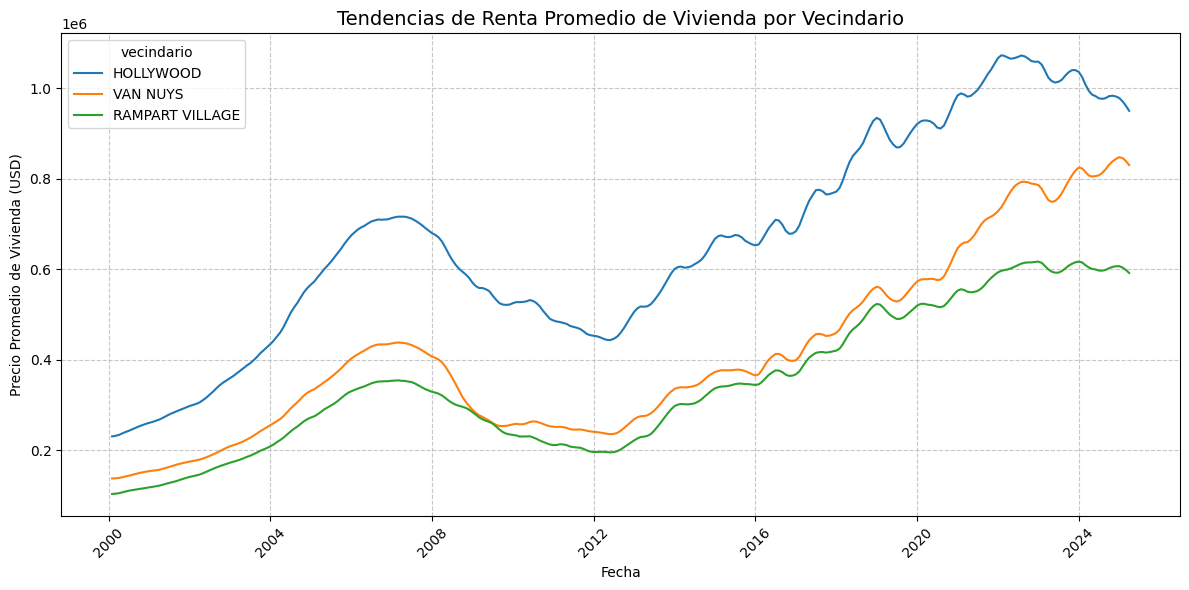

In [141]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_housing_selected, x='Fecha', y='Precio', hue='vecindario')

plt.title('Tendencias de Renta Promedio de Vivienda por Vecindario', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Precio Promedio de Vivienda (USD)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

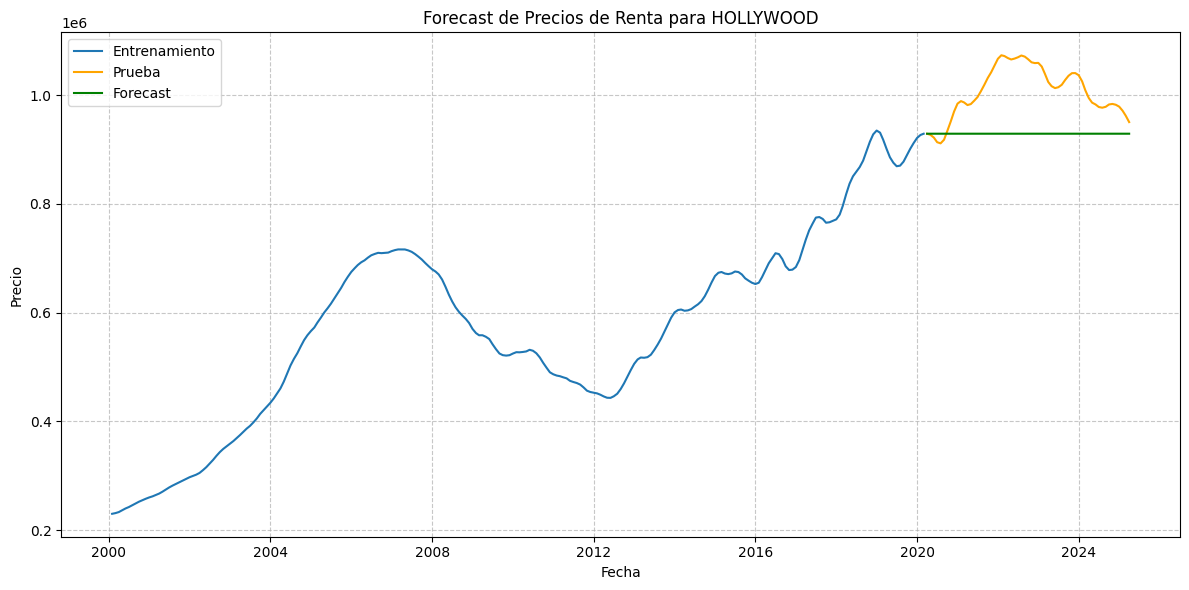

                               SARIMAX Results                                
Dep. Variable:                 Precio   No. Observations:                  242
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2502.174
Date:                Wed, 07 May 2025   AIC                           5010.348
Time:                        23:29:40   BIC                           5020.802
Sample:                    01-31-2000   HQIC                          5014.560
                         - 02-29-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9999      0.470     -2.128      0.033      -1.921      -0.079
ma.L1          0.9998      0.501      1.994      0.046       0.017       1.983
sigma2      6.096e+07   2.48e-08   2.46e+15      0.0

In [142]:
vecindario_forecast = 'HOLLYWOOD'
df_forecast = df_housing_long[df_housing_long['vecindario'] == vecindario_forecast].copy()

df_forecast = df_forecast.sort_values('Fecha')

serie_temporal = df_forecast.set_index('Fecha')['Precio']

train_size = int(len(serie_temporal) * 0.8)
train, test = serie_temporal[:train_size], serie_temporal[train_size:]

model = ARIMA(train, order=(1, 1, 1)) 
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(train, label='Entrenamiento')
plt.plot(test, label='Prueba', color='orange')
plt.plot(test.index, forecast, label='Forecast', color='green')
plt.title(f'Forecast de Precios de Renta para {vecindario_forecast}')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(model_fit.summary())

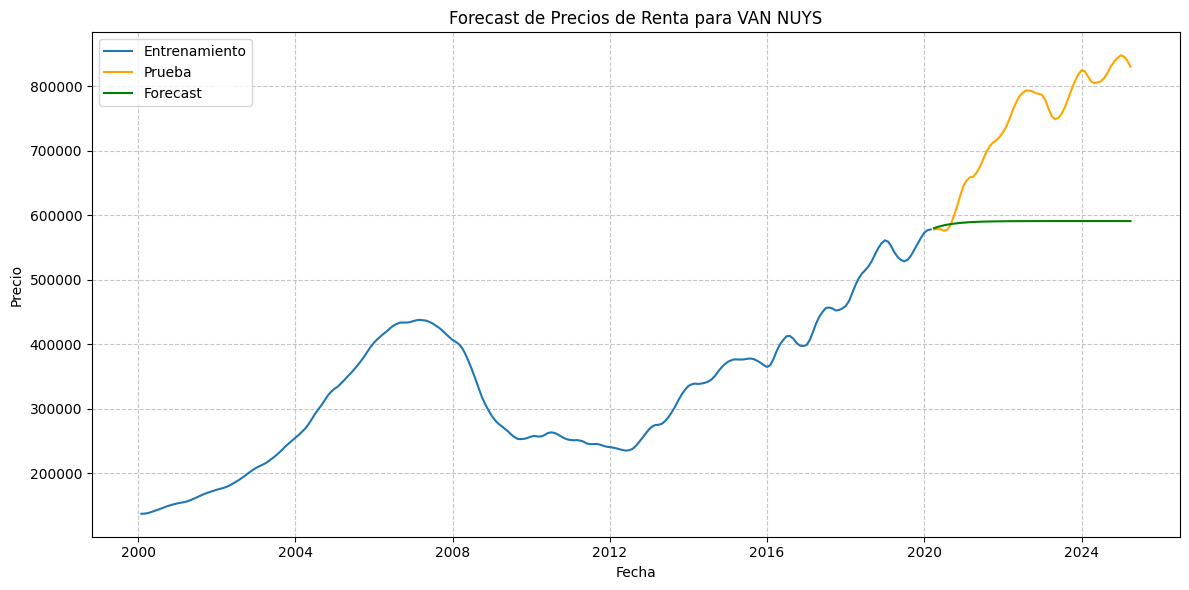

                               SARIMAX Results                                
Dep. Variable:                 Precio   No. Observations:                  242
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2356.733
Date:                Wed, 07 May 2025   AIC                           4719.467
Time:                        23:29:40   BIC                           4729.921
Sample:                    01-31-2000   HQIC                          4723.679
                         - 02-29-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8460      0.033     25.912      0.000       0.782       0.910
ma.L1         -0.7227      0.040    -18.246      0.000      -0.800      -0.645
sigma2      1.791e+07   4.46e-11   4.01e+17      0.0

In [ ]:
vecindario_forecast = 'VAN NUYS'
df_forecast = df_housing_long[df_housing_long['vecindario'] == vecindario_forecast].copy()

df_forecast = df_forecast.sort_values('Fecha')

serie_temporal = df_forecast.set_index('Fecha')['Precio']

train_size = int(len(serie_temporal) * 0.8)
train, test = serie_temporal[:train_size], serie_temporal[train_size:]

model = ARIMA(train, order=(1, 1, 1))  
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(train, label='Entrenamiento')
plt.plot(test, label='Prueba', color='orange')
plt.plot(test.index, forecast, label='Forecast', color='green')
plt.title(f'Forecast de Precios de Renta para {vecindario_forecast}')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(model_fit.summary())

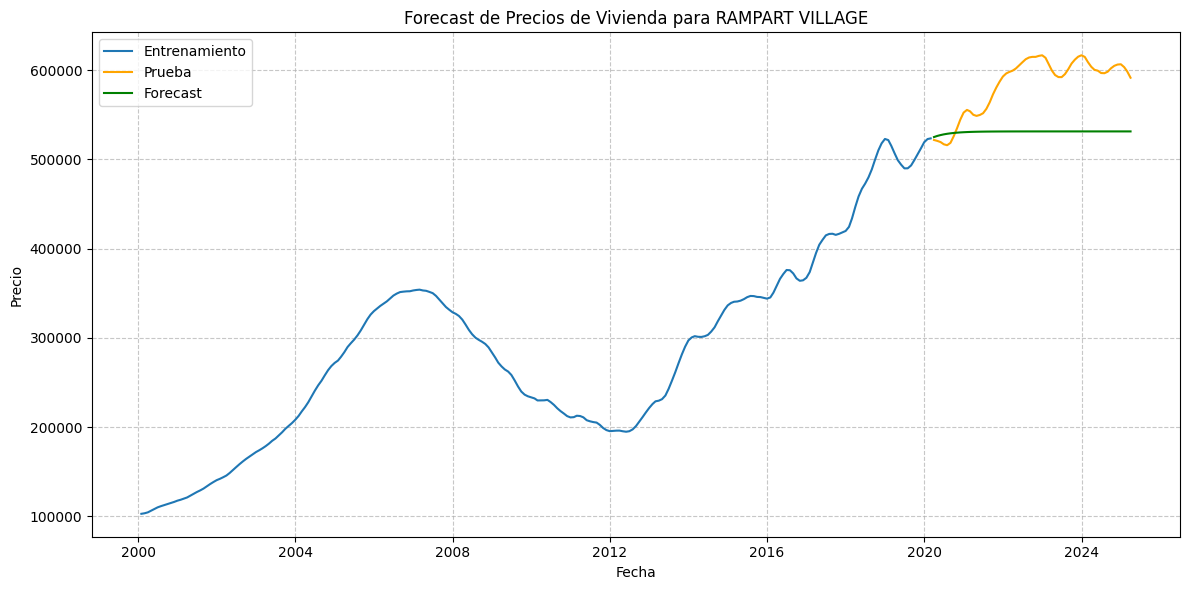

                               SARIMAX Results                                
Dep. Variable:                 Precio   No. Observations:                  242
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2304.559
Date:                Wed, 07 May 2025   AIC                           4615.119
Time:                        23:29:40   BIC                           4625.573
Sample:                    01-31-2000   HQIC                          4619.330
                         - 02-29-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8061      0.031     25.738      0.000       0.745       0.868
ma.L1         -0.6423      0.038    -16.882      0.000      -0.717      -0.568
sigma2      1.145e+07   5.85e-11   1.96e+17      0.0

In [144]:
vecindario_forecast = 'RAMPART VILLAGE'
df_forecast = df_housing_long[df_housing_long['vecindario'] == vecindario_forecast].copy()

df_forecast = df_forecast.sort_values('Fecha')

serie_temporal = df_forecast.set_index('Fecha')['Precio']

train_size = int(len(serie_temporal) * 0.8)
train, test = serie_temporal[:train_size], serie_temporal[train_size:]

model = ARIMA(train, order=(1, 1, 1)) 
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(train, label='Entrenamiento')
plt.plot(test, label='Prueba', color='orange')
plt.plot(test.index, forecast, label='Forecast', color='green')
plt.title(f'Forecast de Precios de Vivienda para {vecindario_forecast}')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(model_fit.summary())